# Team Lovelace - Behind the Scenes of Stardom: Decoding the Patterns in Actors' Careers <img src="Data/Images/LinkedIn_logo_initials.png" width="25">

Welcome to our project notebook for Milestone P2! In this phase, our team has worked on refining our project proposal and conducting preliminary analyses to set the stage for a successful data exploration and analysis journey. 

Our project aims to analyze the careers of actors present in our dataset. In this milestone, we delve into initial analyses and data handling tasks, ensuring that our proposed project is feasible given the available datasets.

## Imports


In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.stats import ttest_ind, pearsonr
from tqdm import tqdm
from rapidfuzz import fuzz
from operator import itemgetter
from matplotlib import colors

import sys
sys.path.insert(0, "./Code")

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%autoreload 2

## Loading Datasets

In [4]:
# Setting the paths to the data folders
DATA_FOLDER = "Data/"
CMU_PATH = DATA_FOLDER + "MovieSummaries/"
IMDB_PATH = DATA_FOLDER + "IMDb/"
OSCARS_PATH = DATA_FOLDER + "Oscars/"

In [3]:
# Reading CMU Movie & Character metadata
cmu_movies_raw = pd.read_csv(CMU_PATH + "movie.metadata.tsv", sep="\t", )
cmu_characters_raw = pd.read_csv(CMU_PATH + "character.metadata.tsv", sep="\t")

# Reading IMDb basics and ratings data
imdb_movies_raw = pd.read_csv(
    IMDB_PATH + "title.basics.tsv.gz", sep="\t", compression="gzip"
)
imdb_ratings_raw = pd.read_csv(
    IMDB_PATH + "title.ratings.tsv.gz", sep="\t", compression="gzip"
)

# Reading Oscars data
oscars_raw = pd.read_csv(
    OSCARS_PATH + "the_oscar_award.csv",
)

### Renaming Columns

Both CMU datasets, `cmu_movies_raw` and `cmu_characters_raw`, initially lacked column names. To address this, we have provided names in the cell below. For the CMU dataset, you can refer to the descriptions of each column [here](http://www.cs.cmu.edu/~ark/personas/). 


In [4]:
cmu_movies_raw.columns = [
    "wikiID",
    "fbID",
    "movieName",
    "releaseDate",
    "boxOffice",
    "runtime",
    "languages",
    "countries",
    "genres",
]

cmu_characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "actorDOB",
    "actorGender",
    "actorHeight",
    "actorEthnicity",
    "actorName",
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

cmu_movies_raw.drop(columns="wikiID", inplace=True)
cmu_characters_raw.drop(columns="wikiID", inplace=True)

To ensure consistency in column names across datasets, we have renamed some columns in the other datasets (to match the conventions of the CMU dataset) in the cell below. The descriptions related to the columns of the IMDb and Oscars datasets used can be found [here](https://developer.imdb.com/non-commercial-datasets/) and [here](https://www.kaggle.com/datasets/unanimad/the-oscar-award), respectively. 

In [5]:
imdb_movies_raw.rename(
    columns={
        "tconst": "imdbID",
        "primaryTitle": "movieName",
        "startYear": "releaseYear",
        "runtimeMinutes": "runtime",
    },
    inplace=True
)

imdb_ratings_raw.rename(
    columns={
        "tconst": "imdbID",
    },
    inplace=True
)

oscars_raw.rename(
    columns={
        "year_film": "releaseYear",
        "year_ceremony": "yearCeremony",
        "name": "actorName",
        "film": "movieName",
    },
    inplace=True
)

## Merging Datasets

Before merging the datasets, it is important to clean and standardize the column formats for the columns we intend to merge on. To facilitate this process, we create copies of our raw dataframes. This ensures that we don't need to reload them if we want to start the cleaning process from scratch.

In [6]:
cmu_movies = cmu_movies_raw.copy()
cmu_characters = cmu_characters_raw.copy()

imdb_movies = imdb_movies_raw.copy()
imdb_ratings = imdb_ratings_raw.copy()

oscars = oscars_raw.copy()

### Cleaning columns `movieName` & `actorName`

As we want to merge the `cmu_movies` and `cmu_characters` datasets on the `movieName` column (because we don't have matching IDs for both), we first standardize the movie titles by removing accents, special characters, extra spaces and converting to lowercase to increase the likelihood of finding a match. 
Likewise, we do the same thing for the actor names in `cmu_characters` and the `oscars` dataset.

In [7]:
# Pre-filtering IMDb movies
# Keep only movies and shorts
imdb_movies = imdb_movies[imdb_movies['titleType'].isin(['movie', 'short', 'tvMovie', 'tvShort'])]
# Remove data for movies with no name
imdb_movies.dropna(subset='movieName', inplace=True)
oscars.dropna(subset='movieName', inplace=True)
# Likewise for actors with no name
cmu_characters.dropna(subset='actorName', inplace=True)

In [8]:
# Standardize movie titles and actor names by removing accents, special characters, extra spaces and converting to lowercase
cmu_movies['movieNameStd'] = cmu_movies['movieName'].apply(standardize_str)
imdb_movies['movieName'] = imdb_movies['movieName'].apply(standardize_str)
imdb_movies.rename(columns={'movieName': 'movieNameStd'}, inplace=True)
oscars['movieNameStd'] = oscars['movieName'].apply(standardize_str)

oscars['actorName'] = oscars['actorName'].apply(standardize_str)
oscars.rename(columns={'actorName': 'actorNameStd'}, inplace=True)
cmu_characters['actorNameStd'] = cmu_characters['actorName'].apply(standardize_str)

### Cleaning column `releaseDate`

The `cmu_movies` and `cmu_characters` dataset exhibit variable date formats, with some entries providing day, month, and year, while others only contain the year. To enhance clarity and facilitate analysis, we've decided to split the `releaseDate` column into separate columns, `releaseMonth` and `releaseYear`. For the `imdb_movies` and `oscars` datasets, the release dates are provided in the year-only format.

In [9]:
# Cmu movies & characters
# Months
cmu_movies["releaseMonth"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", dayfirst=True
).dt.month
cmu_characters["releaseMonth"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", yearfirst=True
).dt.month
# Year
cmu_movies["releaseYear"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year
cmu_characters["releaseYear"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year

# Drop releaseDate column
cmu_movies.drop(columns=["releaseDate"], inplace=True)
cmu_characters.drop(columns=["releaseDate"], inplace=True)

# IMDb & Oscars
imdb_movies["releaseYear"] = pd.to_datetime(
    imdb_movies["releaseYear"], errors="coerce", format="%Y"
).dt.year

oscars["releaseYear"] = pd.to_datetime(
    oscars["releaseYear"], errors="coerce", format="%Y"
).dt.year

In [10]:
# Drop movie with same title and release date to avoid issues when merging
cmu_movies.drop_duplicates(subset=["movieNameStd", "releaseMonth", "releaseYear"], inplace=True)
imdb_movies.drop_duplicates(subset=["movieNameStd", "releaseYear"], inplace=True)

### Formatting column `runtime`

The `runtime` column for the `imdb_movies` dataset contains non-numerical values (such as '\N') instead of 'NaN'.

In [11]:
imdb_movies["runtime"] = pd.to_numeric(imdb_movies["runtime"], errors="coerce")

### Cleaning oscars dataset
The `oscars` dataset contains not only actors but the entire movie industry, leading to the inclusion of numerous categories that are outside the scope of our analysis. Therefore, we filter the dataset before merging to retain only the rows containing the categories related to actors, specified in the list below.

In [12]:
categories_to_keep = [
    "ACTOR",
    "ACTOR IN A LEADING ROLE",
    "ACTOR IN A SUPPORTING ROLE",
    "ACTRESS",
    "ACTRESS IN A LEADING ROLE",
    "ACTRESS IN A SUPPORTING ROLE",
]

oscars["category"] = oscars["category"].apply(lambda category: category if category in categories_to_keep else np.nan)

### Extracting ethnicities

In the original dataset, ethnicities are represented as Freebase IDs. Such IDs being difficult to interpret, we replaced them by their real name. The map used to convert IDs to the name of the ethnicity is extracted from the full freebase database in `Code/extract-ethnicities.ipynb`.

In [13]:
# Read the map that converts ethnicities
map_ethnicities = eval('\n'.join(open("Data/MovieSummaries/ethnicity.json").readlines()))

# Apply the conversion on the dataset
cmu_characters.actorEthnicity = cmu_characters.actorEthnicity.apply(
    lambda eth: map_ethnicities.get("m." + eth[3:] if type(eth) == type("") else "", None))

cmu_characters.actorEthnicity.value_counts()

actorEthnicity
Indian people                            16351
African American                         10159
Jewish people                            10121
White people                              2307
White American                            2250
                                         ...  
Lebanese people in the United Kingdom        1
Métis people                                 1
Ossetians                                    1
Sinhala- Tamil                               1
Georgians                                    1
Name: count, Length: 249, dtype: int64

### Merging the datasets

In the following cells, we will merge our datasets together in order to populate the CMU movies and characters dataframes with information from the IMDb/Budget/Oscars datasets.

1. **IMDb Movie and IMDb Ratings:**
   - We left merge the `imdb_movies` dataset with the `imdb_ratings` dataset on the common `imdbID` identifier column in order to populate the `imdb` dataframe with IMDb movie ratings.
      
2. **CMU Movies and IMDb Data:**
    - We then merge the `cmu_movies` dataset with the previously merged `imdb` dataframe in order to populate the `cmu_movies` dataframe with IMDb information. 
    - Since we don't have a common unique identifier between the two datasets, we perform the left merge on the `movieNameStd` and `releaseYear` columns. 
    - To increase the accuracy of the merge, we first try to fuzzy match the movie titles with a similarity threshold of 95. To further improve the merge accuracy, we compare the `runtime` columns and remove the IMDb information for those that do not match within a tolerance of 5 minutes. When only one of the entries is null, we use the other to populate the merged `runtime` column.
        
3. **CMU Characters and Oscars:**
    - We merge the `cmu_characters` dataframe with the `oscars` dataframe on the common `actorNameStd`, `movieNameStd` and `releaseYear` columns to populate the `cmu_characters` dataframe with Oscars information using a left join.

In [14]:
# Merging IMDb movies with IMDb ratings
imdb = pd.merge(imdb_movies, imdb_ratings, how='left', on='imdbID')

In [16]:
# Merging CMU movies with IMDb movies

# Using rapidfuzz library to perform fast fuzzy matching between the movie titles
# Group the imdb dataframe by releaseYear to speed up the search
grouped_imdb = imdb.groupby('releaseYear')
# Enable tqdm pandas integration
tqdm.pandas(desc="Retrieving best matches")
# Compute the best match for each title in CMU movies with a similarity threshold of 95
cmu_movies['matched_title'] = cmu_movies.progress_apply(get_best_match, args=(grouped_imdb,), scorer=fuzz.WRatio,
                                                        threshold=95, axis=1)

# Perform the merge on the matched titles and releaseYear
movies_merged = pd.merge(cmu_movies, imdb, left_on=['matched_title', 'releaseYear'],
                         right_on=['movieNameStd', 'releaseYear'], how='left', suffixes=['Cmu', 'Imdb'])

# To improve the accuracy of the merge, we filter out IMDb data for movies where runtime doesn't match (with tolerance)
runtime_tol = 5  # Allow for 5 minutes of leeway in runtime between IMDb and CMU

# When only one of the runtimes is nan, use the other
movies_merged['runtimeCmu'] = np.where(
    # If runtimeCmu is nan but runtimeImdb is not, use runtimeImdb else keep runtimeCmu
    pd.isna(movies_merged['runtimeCmu']) & pd.notna(movies_merged['runtimeImdb']),
    movies_merged['runtimeImdb'],
    movies_merged['runtimeCmu']
)

# Identify rows where both runtimes are not NaN and the difference is not within tolerance
mask = pd.notna(movies_merged['runtimeCmu']) & pd.notna(movies_merged['runtimeImdb']) & (
        abs(movies_merged['runtimeCmu'] - movies_merged['runtimeImdb']) > runtime_tol)

# Remove IMDb data when the runtimes are not within tolerance
movies_merged.loc[mask, ['imdbID', 'titleType', 'originalTitle', 'isAdult', 'endYear', 'genresImdb', 'averageRating',
                         'numVotes']] = np.nan

# Drop extra columns used during title and runtime matching
movies_merged.drop(['matched_title', 'movieNameStdImdb', 'movieNameStdCmu', 'runtimeImdb'], axis=1, inplace=True)
movies_merged.rename(columns={'runtimeCmu': 'runtime'}, inplace=True)

Retrieving best matches:   0%|          | 99/81626 [00:00<10:44, 126.50it/s]

Retrieving best matches: 100%|██████████| 81626/81626 [10:30<00:00, 129.46it/s]


In [17]:
print(f"Proportion of missing IMDb IDs: {movies_merged.imdbID.isna().sum() / movies_merged.shape[0]:.3f}")
print(f"Proportion of missing IMDb ratings: {movies_merged.averageRating.isna().sum() / movies_merged.shape[0]:.3f}")
print(f"Proportion of missing box office revenues: {movies_merged.boxOffice.isna().sum() / movies_merged.shape[0]:.3f}")

Proportion of missing IMDb IDs: 0.379
Proportion of missing IMDb ratings: 0.441
Proportion of missing box office revenues: 0.897


In our analysis of movie runtimes, we focus on films with durations ranging from 10 minutes to 4 hours. Therefore, we have assigned a value of `np.nan` to runtimes falling outside this range (leading to a slight increase in the number of missing values).

In [18]:
print(
    f"Percentage of missing values before filtering: {movies_merged['runtime'].isnull().sum() / len(movies_merged):.2%}")

movies_merged["runtime"] = (
    movies_merged["runtime"]
    .apply(lambda runtime: runtime if (runtime >= 10 and runtime <= 4 * 60) else np.nan)
)

print(
    f"Percentage of missing values after filtering: {movies_merged['runtime'].isnull().sum() / len(movies_merged):.2%}")

Percentage of missing values before filtering: 15.15%
Percentage of missing values after filtering: 18.14%


In [19]:
# Merging CMU Characters with Oscars
characters_merged = pd.merge(
    cmu_characters.merge(
        cmu_movies[["fbID", "movieNameStd"]], how="left", on="fbID"
    ),  # Add movieName in cmu_characters
    oscars,
    how="left",
    on=["actorNameStd", "releaseYear", "movieNameStd"],
)
# Remove standardized actor names
characters_merged.drop(columns=["actorNameStd"], inplace=True)

As before, we copy our DataFrame to avoid running the merge cell in case we make modifications incorrectly and wish to restart from this point.

In [20]:
movies = movies_merged.copy()
characters = characters_merged.copy()

## `Actors` dataframe
Given that our analysis primarily centers on actors rather than movies characters, we construct a new dataframe `actors` from `characters` focusing on actor-related information. The columns are rearranged to provide a perspective centered on actors. Following this, we filter out rows without a Freebase actor ID, as they only contain character information without actor-related details.

In [21]:
actors = characters[
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
        "fbID",
        "ageAtMovieRelease",
        "category",
        "winner",
    ]
]

actors = actors.sort_values(by=actors.columns.to_list(), ignore_index=True)
actors = actors.dropna(subset="fbActorID")

### Cleaning `actorDOB` & `yearOfBirth`
The `actorDOB` column is converted to a datetime format. Additionally, we add a new column, `YearOfBirth` for our analysis.

In [22]:
actors['actorDOB'] = pd.to_datetime(actors['actorDOB'], errors='coerce')
actors['yearOfBirth'] = actors['actorDOB'].dt.year
print("Date of Birth")
print(actors['actorDOB'].describe())
print("\nYear of Birth")
print(actors['yearOfBirth'].describe())

Date of Birth
count                           329890
mean     1943-05-29 03:30:11.796659456
min                1796-09-20 00:00:00
25%                1922-09-01 00:00:00
50%                1948-02-25 00:00:00
75%                1966-07-11 00:00:00
max                2011-09-02 00:00:00
Name: actorDOB, dtype: object

Year of Birth
count    329890.000000
mean       1942.908039
std          29.010034
min        1796.000000
25%        1922.000000
50%        1948.000000
75%        1966.000000
max        2011.000000
Name: yearOfBirth, dtype: float64


### Cleaning `ageAtMovieRelease` column

To clean the `ageAtMovieRelease` column, we assess its coherence with the movie release date and the actor's year of birth. This is achieved by calculating the difference between the sum of the age at movie release and the actor's age at movie release, and the movie's release year. If the difference falls outside the range of $[-1, 0, 1]$, we replace the age with `np.nan`. In cases where any of the involved columns contain NaN values, making the difference calculation impossible, we choose to retain the existing age values. However, we still encountered values where the resulting ages were negative, so we filtered those values as well.

In [23]:
# Merge the "actors" DataFrame with selected columns from the "movies" DataFrame
actors_movies_releaseYear = actors.merge(
    movies[["fbID", "releaseYear"]], how="left", on="fbID"
)

# Difference between the (age at movie release + year of birth) - movie release year
actors_movies_releaseYear["delta"] = (
        actors_movies_releaseYear["ageAtMovieRelease"]
        + actors_movies_releaseYear["yearOfBirth"]
        - actors_movies_releaseYear["releaseYear"]
)

# Identify movies where the calculated age difference is not within the
# expected range [-1, 0, 1] or the difference couldn't be calculated
actors_movies_releaseYear["notValid"] = actors_movies_releaseYear["delta"].apply(
    lambda delta: False if (delta in [-1, 0, 1] or np.isnan(delta)) else True
)

# Mask ages at movie release where the calculated difference is not valid with np.nan
actors_movies_releaseYear["ageAtMovieRelease"] = actors_movies_releaseYear[
    "ageAtMovieRelease"
].mask(actors_movies_releaseYear["notValid"], np.nan)

# Replace negative ages with np.nan
actors_movies_releaseYear["ageAtMovieRelease"] = actors_movies_releaseYear[
    "ageAtMovieRelease"
].apply(lambda age: age if age > 0 else np.nan)

actors["ageAtMovieRelease"] = actors_movies_releaseYear["ageAtMovieRelease"]
actors["ageAtMovieRelease"].describe()

count    292125.000000
mean         37.897910
std          14.078222
min           1.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: ageAtMovieRelease, dtype: float64

To ensure a single row for each actor, we use our dataset aggregation function called `actors_agg` (refer to [helpers.py](helpers.py)). The `fbID` column, which contains the movies featuring the actor, is aggregated into a list. Additionally, the `ageAtMovieRelease,` `category,` and `winner` columns are aggregated into dictionaries. In these dictionaries, the keys represent the movies, and the values contain the corresponding `ageAtMovieRelease,` `category,` and `winner` values for each column, respectively. If an actor did not participate in any Oscars ceremony, the `category` and `winner` columns are assigned the value NaN.

In [24]:
actors = actors.groupby(
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
        "yearOfBirth"
    ],
    dropna=False
).apply(actors_agg).reset_index()

In [25]:
# Add number of movies for each actor in numMovies column
actors["numMovies"] = actors["fbID"].apply(
    lambda x: len(x)
)
actors['numMovies'].describe()

count    135422.000000
mean          3.293616
std           7.644870
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         575.000000
Name: numMovies, dtype: float64

For expanding the `actors` dataset based on movies, we developed the `explode_on_movies` function to manage the columns containing dictionaries.

In [26]:
explode_on_movies(actors)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,/m/03qk61v,44.0,NaN,NaN,11
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,/m/047dv64,NaN,NaN,NaN,11
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,/m/051wrdv,35.0,NaN,NaN,11
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,/m/06c5z_,33.0,NaN,NaN,11
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,/m/06zm9p7,45.0,NaN,NaN,11
...,...,...,...,...,...,...,...,...,...,...,...,...
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,1967.0,/m/0k3lpxc,46.0,None,None,54
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,1967.0,/m/0kvf09,42.0,None,None,54
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,1967.0,/m/0kvf6s,40.0,None,None,54
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,1967.0,/m/0q9b0,32.0,None,None,54


In [27]:
print("MOVIES")
display(movies)
print("ACTORS")
display(actors)

MOVIES


,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes
0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2.0,2000.0,tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0,\N,Drama,6.0,69.0
1,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,1988.0,tt0094806,movie,Brun bitter,0,\N,"Crime,Drama",5.6,40.0
2,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN,1987.0,tt0094320,movie,White of the Eye,0,\N,"Horror,Mystery,Thriller",6.1,2885.0
3,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN,1983.0,tt0083949,movie,Die flambierte Frau,0,\N,Drama,6.0,621.0
4,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",5.0,1913.0,tt0002894,short,The Gangsters,0,\N,"Comedy,Short",6.8,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81621,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",3.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81622,/m/0g4pl34,Knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",1.0,2011.0,tt1606259,movie,Knuckle,0,\N,"Biography,Documentary,Drama",6.8,3190.0
81623,/m/02pygw1,Another Nice Mess,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",9.0,1972.0,tt0362411,movie,Another Nice Mess,0,\N,Comedy,5.8,110.0
81624,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ACTORS


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,NaN,1977.0,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48
...,...,...,...,...,...,...,...,...,...,...,...,...
135417,/m/0z58,Ardal O'Hanlon,M,1965-10-08,NaN,NaN,1965.0,[/m/027cvd8],NaN,NaN,NaN,1
135418,/m/0z9q0,"José Luis Rodríguez ""El Puma""",M,1943-01-14,NaN,NaN,1943.0,[/m/0gls5qd],{'/m/0gls5qd': 69.0},NaN,NaN,1
135419,/m/0zcb7,Marcus Giamatti,M,1961-10-03,1.850,NaN,1961.0,"[/m/02drs7, /m/03b1xl, /m/047fs6w, /m/080kkcx,...","{'/m/02drs7': 40.0, '/m/03b1xl': 29.0, '/m/047...",NaN,NaN,6
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,1967.0,"[/m/01510v, /m/01hv3t, /m/01pgnr, /m/024tb7, /...","{'/m/01510v': 31.0, '/m/01hv3t': 30.0, '/m/01p...",{'/m/050gkf': 'ACTOR IN A SUPPORTING ROLE'},{'/m/050gkf': False},54


In [28]:
# Saving intermediate dataframes
movies.to_csv(DATA_FOLDER + "movies.csv", index=False)
actors.to_csv(DATA_FOLDER + "actors.csv", index=False)

## Career Characterization

The goal of this section is to study the different characteristics of the career trajectories of the actors, aiming to answer the question: What characterizes the career evolution of actors? The acting careers will be represented as profile sequences (which are yearly time series of acting jobs) and their various characteristics and properties will be analyzed. This will also include the exploration of potential gender inequalities in the multiple factors that will be considered.  


In the following, we will use the previously constructed actors-oriented dataframe containing only full careers.

In [60]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genresCmu": parse_list,
    },
)

In [61]:
print("Total number of actors:", actors_load.shape[0])

Total number of actors: 135422


There are 135'422 actors in our dataset. It is likely that the dataset contains a diverse range of individuals with varying levels of involvement in the film industry, including many actors who have only appeared in a few movies ("one-timers" or relatively minor contributors to the overall landscape of the industry). Let us look at the number of movies played by the actors to confirm that.

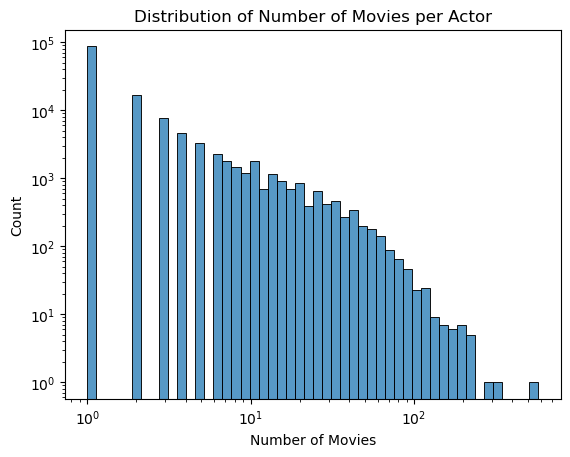

Number of actors that have played in only one movie: 87003
Number of actors that have played in less than 10 movies: 125985


In [62]:
sns.histplot(data=actors_load, x='numMovies', bins=50, log_scale=(True, True))
plt.title("Distribution of Number of Movies per Actor")
plt.xlabel("Number of Movies")
plt.ylabel("Count")
plt.show()

num_actors_one_movie = (actors_load['numMovies'] == 1).sum()
print(f"Number of actors that have played in only one movie: {num_actors_one_movie}")
num_actors_ten_movies = (actors_load['numMovies'] < 10).sum()
print(f"Number of actors that have played in less than 10 movies: {num_actors_ten_movies}")

Let us now look at the year of birth of the actors considered.

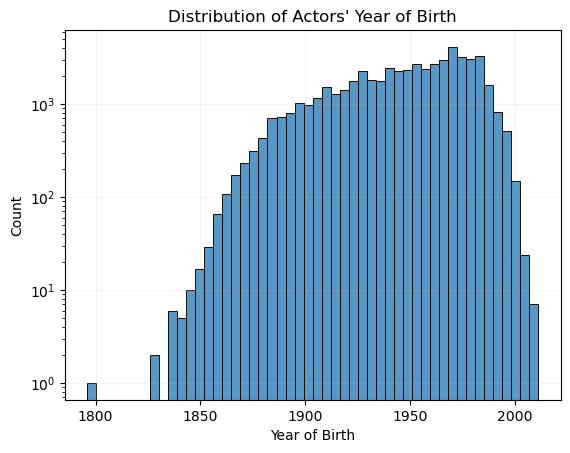

The minimum year of birth is 1796.0 and the maximum year of birth is 2011.0.


In [64]:
actors_load['actorDOB'] = pd.to_datetime(actors_load['actorDOB'], errors="coerce") 
actors_load['yearOfBirth'] = actors_load['actorDOB'].dt.year 

# Plot histogram
sns.histplot(data=actors_load, x='yearOfBirth', bins=50, log_scale=(False, True))
plt.title("Distribution of Actors' Year of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

min_year = actors_load['yearOfBirth'].min()
max_year = actors_load['yearOfBirth'].max()

print(f"The minimum year of birth is {min_year} and the maximum year of birth is {max_year}.")


From 1854 to 1970, there appears to be a noticeable increase in the number of actors born during this period. This rise could be indicative of several factors, such as the increasing popularity of movies as a form of entertainment, the growth of the film industry, and the increasing recognition of acting as a viable and esteemed profession. A decrease in the number of actors can be noticed after 1975, which can be explained by the fact that some 'future' actors may have not started their career yet.

To ensure an accurate assessment of careers and to avoid erroneously identifying a mid-career movie as the initial one due to a lack of data before it, or as the last one while the actor could still be actively engaged in his career, we have to determine which are the actors with a full career in our dataset.

For the career start ages of actors, we can calculate the age at which an actor first appears in a movie within our dataset. To avoid uncorrectly identifying a mid-career movie, we will consider actors born after the release year of the earliest movie included in our dataset.

In [65]:
print('Minimum release year for movies dataset: ', movies_load['releaseYear'].min())
actors_after_1888 = actors_load[actors_load['yearOfBirth'] > 1888]
print('Number of actors after 1888: ', actors_after_1888.shape[0])

Minimum release year for movies dataset:  1888.0
Number of actors after 1888:  50828


In [66]:
# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan


# Apply the function to the ageAtMovieRelease column
actors_after_1888['ageAtFirstMovie'] = actors_after_1888['ageAtMovieRelease'].apply(get_min_age)

To obtain the durations of the actors' careers, we must identify the final year in which they make an appearance in a movie, which is not an easy task as some of our actors are still actively engaged in their careers.

In [67]:
print('Maximum release year for movies dataset: ', movies_load['releaseYear'].max())
actors_full_career = actors_after_1888[actors_after_1888['yearOfBirth'] < movies_load['releaseYear'].max() - 61]
print('Number of actors between 1888 and 1967: ', actors_full_career.shape[0])

Maximum release year for movies dataset:  2016.0
Number of actors between 1888 and 1967:  25344


In [68]:
# Define a function to extract the maximum age from the ageAtMovieRelease dictionary
def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']

To choose the upper limit for the birth years of actors, we conducted an analysis of the age at the last movie appearance within a specified interval that should be immune to the influence of cutting points (taking into account a 100-year margin). The results revealed an average age of approximately 60.89 years, which thus taken off from 2017, last movie release year in our dataset.

Mean age at last movie appearance: 49.85
Median age at last movie appearance: 49.00


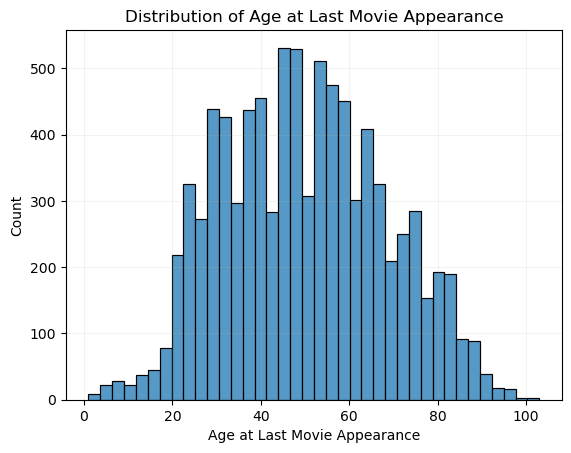

In [69]:
# Mean and median of age at last movie appearance
age_last_movie = actors_full_career[actors_full_career.yearOfBirth < 2017 - 90]['ageAtLastMovie']
print(f"Mean age at last movie appearance: {age_last_movie.mean():.2f}")
print(f"Median age at last movie appearance: {age_last_movie.median():.2f}")

# Plot histogram of age at last movie appearance
sns.histplot(data=actors_full_career[actors_full_career.yearOfBirth < 2017 - 90], x='ageAtLastMovie')
plt.title('Distribution of Age at Last Movie Appearance')
plt.xlabel('Age at Last Movie Appearance')
plt.ylabel('Count')
plt.grid(alpha=0.15)
plt.show()

In [70]:
print("Number of actors with a full career in constructed dataframe:", actors_full_career.size)

print("Minimum date of birth of actor in constructed dataframe:", actors_full_career['actorDOB'].min())
print("Maximum date of birth of actor in constructed dataframe:", actors_full_career['actorDOB'].max())

print("Minimum release year of movie:", movies_load['releaseYear'].min())
print("Maximum release year of first movie:", movies_load['releaseYear'].max())

actors_full_career.head()

Number of actors with a full career in constructed dataframe: 380160
Minimum date of birth of actor in constructed dataframe: 1889-01-01 00:00:00
Maximum date of birth of actor in constructed dataframe: 1954-12-31 00:00:00
Minimum release year of movie: 1888.0
Maximum release year of first movie: 2016.0


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,ageAtFirstMovie,ageAtLastMovie,careerLength
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,67.0,67.0,0.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,28.0,72.0,44.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.74,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,28.0,69.0,41.0
6,/m/011_24,Les Brown,M,1912-03-14,NaN,NaN,1912.0,"[/m/02stxk, /m/09n9rnb]","{'/m/02stxk': 50.0, '/m/09n9rnb': 30.0}",NaN,NaN,2,30.0,50.0,20.0
8,/m/011_3s,Lily Tomlin,F,1939-09-01,1.73,NaN,1939.0,"[/m/027qjyd, /m/028kj0, /m/02phv19, /m/02q3fdr...","{'/m/027qjyd': 52.0, '/m/028kj0': 62.0, '/m/02...",{'/m/0j_t1': 'ACTRESS IN A SUPPORTING ROLE'},{'/m/0j_t1': False},27,37.0,69.0,32.0


First, let's construct the career profile sequence of each actor. The profile sequence is a vector of the length of the maximum career length in our dataset, denoting the number of movies done by an actor for each year of his career. This information will help us analyze and understand the typical career trajectories of actors in our dataset.

Max career length: 90


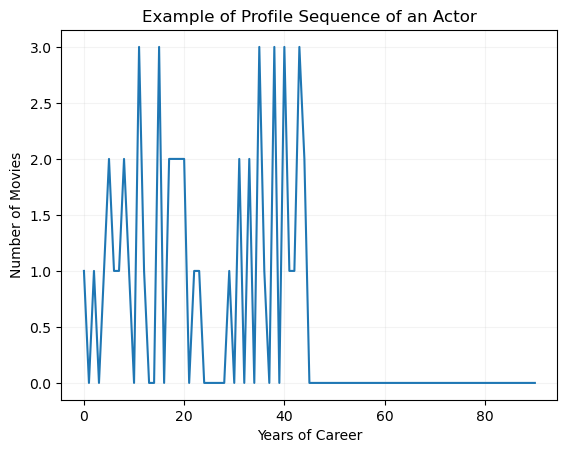

In [71]:
# Get the maximum career length
max_career_length = int(actors_full_career['careerLength'].max())
print(f"Max career length: {max_career_length}")

# Drop rows with missing values in the 'ageAtMovieRelease' column
actors_full_career.dropna(subset=['ageAtMovieRelease'], inplace=True)

# Define a function to calculate the profile sequence for each actor
def get_profile_sequence(x, max_career_length):
    age_at_first_movie = float(x.ageAtFirstMovie)  

    age_list = []
    for value in x.ageAtMovieRelease.values():
        age_list.append(float(value) - age_at_first_movie)
    age_list.sort()

    # Count the number of movies for each age
    movie_count = Counter(age_list)

    # Create a list of size max career length and fill it with zeros
    profile_sequence = [0] * (max_career_length + 1)

    # Fill the list with the number of movies for each age
    for key, value in movie_count.items():
        profile_sequence[int(key)] = value

    return profile_sequence

# Apply the function to calculate the profile sequence for each actor and create a new column 'profileSequence'
actors_full_career['profileSequence'] = actors_full_career.apply(lambda x: get_profile_sequence(x, max_career_length), axis=1)

# Example of career profile sequence of an actor
actor_index = 3 
actor_profile_sequence = actors_full_career.loc[actor_index, 'profileSequence']

# Plot the profile sequence
plt.plot(range(len(actor_profile_sequence)), actor_profile_sequence, linestyle="-")
plt.title("Example of Profile Sequence of an Actor")
plt.xlabel("Years of Career")
plt.ylabel("Number of Movies")
plt.grid(alpha=0.15)
plt.show()

Let's proceed with clustering the profile sequences using K-means to identify different types of career trajectories. 

To determine the optimal number of clusters, we will employ the silhouette score. A higher silhouette score indicates a better-defined separation of clusters. We opted for Euclidean distance over Manhattan distance in our clustering analysis, as its ability to emphasize larger differences across all dimensions, aligns better with our goal of penalizing more significant deviations in career trajectories.

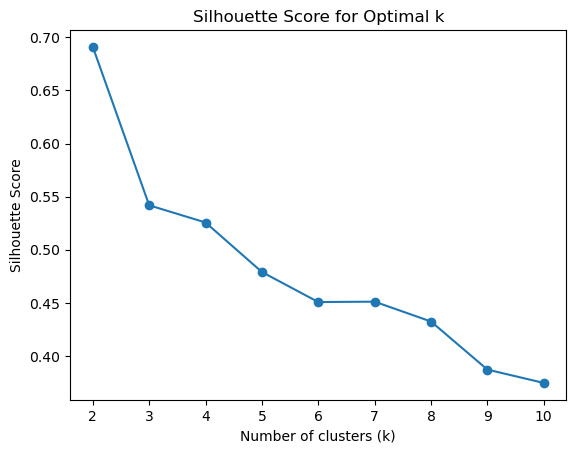

In [72]:
# Get the profile sequences
profile_sequences = actors_full_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The Silhouette score is highest for k = 2, which will thus be adopted in the subsequent step.

In [123]:
# Get the profile sequences
profile_sequences = actors_full_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Define the number of clusters
n_clusters = 2

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=1)

# Fit the data to the K-means algorithm
kmeans.fit(X)

# Get the cluster labels for each profile sequence
cluster_labels = kmeans.labels_

# Add the cluster labels to the actors_full_career dataframe
actors_full_career['clusterLabel'] = cluster_labels

clusterLabel
0    20977
1     1484
dtype: int64


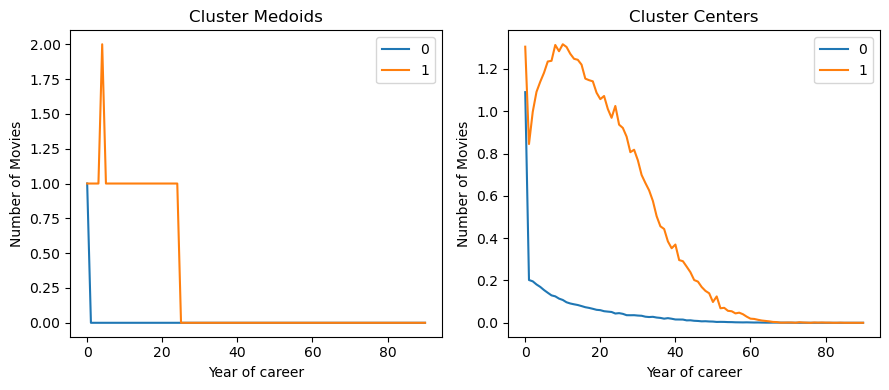

In [125]:
# Group the actors by cluster label
grouped_actors = actors_full_career.groupby('clusterLabel')

# Print the number of actors in each cluster
print(grouped_actors.size())

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(X, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = X[cluster_medoids]    

# Plot the cluster medoids and cluster centers as subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot the cluster medoids
axs[0].plot(medoid_profile_sequences.T)
axs[0].set_xlabel('Year of career')
axs[0].set_ylabel('Number of Movies')
axs[0].set_title('Cluster Medoids')
axs[0].legend(range(n_clusters))

# Plot the cluster centers
axs[1].plot(cluster_centers.T)
axs[1].set_xlabel('Year of career')
axs[1].set_ylabel('Number of Movies')
axs[1].set_title('Cluster Centers')
axs[1].legend(range(n_clusters))

plt.tight_layout()
plt.show()

We can now understand why we obtained k = 2 as the optimal number of clusters. A significant percentage of actors, approximately 90%, have a brief presence in the movie industry, participating in a small number of movies before exiting the scene (as seen in the histogram below). This aligns with the reality of the film industry, as it is very difficult to build an acting career, and many give up. To better distinguish differences in career trajectories among actors with more extensive careers, we will exclude those who have only done less than 5 movies in their acting career.

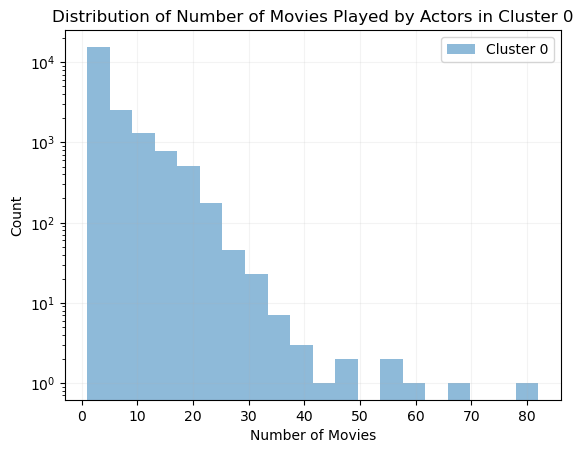

Number of actors that have played in less than 5 movies: 14433


In [126]:
# Plot the distribution of the number of movies played by actors in cluster 0
cluster_0 = grouped_actors.get_group(0)
plt.hist(cluster_0['numMovies'], bins=20, alpha=0.5, label='Cluster 0', log=True)

plt.title('Distribution of Number of Movies Played by Actors in Cluster 0')
plt.xlabel('Number of Movies')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

num_actors_five_movie = (actors_full_career['numMovies'] < 5).sum()
print(f"Number of actors that have played in less than 5 movies: {num_actors_five_movie}")

However, before progressing to actors who have participated in at least 5 movies, let's analyze the gender distribution within the two clusters—namely, the "unsuccessful" and "successful" in building an acting career, which can be seen as equivalent to securing acting jobs consistently.

In [127]:
num_female_actors = actors_full_career["actorGender"].value_counts()["F"]
num_male_actors = actors_full_career["actorGender"].value_counts()["M"]
proportion_male_female = num_female_actors / (num_female_actors + num_male_actors)

print(f"Percentage of female actors: {proportion_male_female:.2%}")

# Group the actors by cluster label
grouped_actors = actors_full_career.groupby('clusterLabel')

# Count the number of females in each cluster
female_counts = grouped_actors['actorGender'].apply(lambda x: (x == 'F').sum())

# Calculate the total number of actors in each cluster
cluster_sizes = grouped_actors.size()

# Calculate the percentage of females in each cluster
female_percentages = (female_counts / cluster_sizes) * 100

# Print the percentage of females in each cluster
for cluster_label, female_percentage in female_percentages.items():
    print(f"Cluster {cluster_label}: {female_percentage:.2f}% of females")


Percentage of female actors: 33.27%
Cluster 0: 33.15% of females
Cluster 1: 25.20% of females


Firstly, it can be noted that the percentage of female actors is significantly lower than the percentage of male actors. However, this percentage further diminishes in the successful group, highlighting gender inequality. To assess whether the difference in percentages is statistically significant, let's conduct a t-test. The fraction of females can be treated as the mean of a boolean variable representing whether an actor is female or not.

In [128]:
# Extract the gender labels for successful and unsuccessful clusters
female_labels_successful = actors_full_career[actors_full_career['clusterLabel'] == 0]['actorGender']
female_labels_unsuccessful = actors_full_career[actors_full_career['clusterLabel'] == 1]['actorGender']

# Perform the t-test
t_stat, p_value = ttest_ind(female_labels_successful == 'F', female_labels_unsuccessful == 'F')

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Check if the difference is statistically significant at a 0.05 significance level
if p_value < 0.05:
    print("The difference in percentages is statistically significant.")
else:
    print("The difference in percentages is not statistically significant.")


t-statistic: 6.3167806788099305
p-value: 2.7207672180603645e-10
The difference in percentages is statistically significant.


Since the p-value is below the significance threshold (commonly set at 0.05), we reject the null hypothesis. This indicates that there is a statistically significant difference between the percentages of female actors in the "successful" and "unsuccessful" in building an acting career clusters. 

In [129]:
# Keep only actors that have played in at least 5 movies
actors_full_extensive_career = actors_full_career[actors_full_career['numMovies'] >= 5]

Now, let's repeat the clustering procedure to see if we can identify distinct career trajectories.

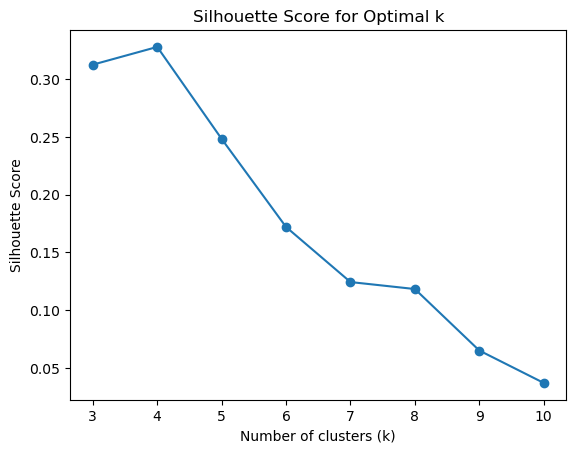

In [130]:
# Get the profile sequences
profile_sequences = actors_full_extensive_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Silhouette Score
silhouette_scores = []
for i in range(3, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Silhouette Score
plt.plot(range(3, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

The Silhouette score is maximized for k = 4.

In [151]:
# Get the profile sequences
profile_sequences = actors_full_extensive_career['profileSequence'].tolist()

# Convert the profile sequences to a numpy array
X = np.array(profile_sequences)

# Define the number of clusters
n_clusters = 4

# Initialize the K-means clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=1)

# Fit the data to the K-means algorithm
kmeans.fit(X)

# Get the cluster labels for each profile sequence
cluster_labels = kmeans.labels_

# Add the cluster labels to the actors_full_extensive_career dataframe
actors_full_extensive_career['clusterLabel'] = cluster_labels

clusterLabel
0    6417
1     609
2      33
3     969
dtype: int64


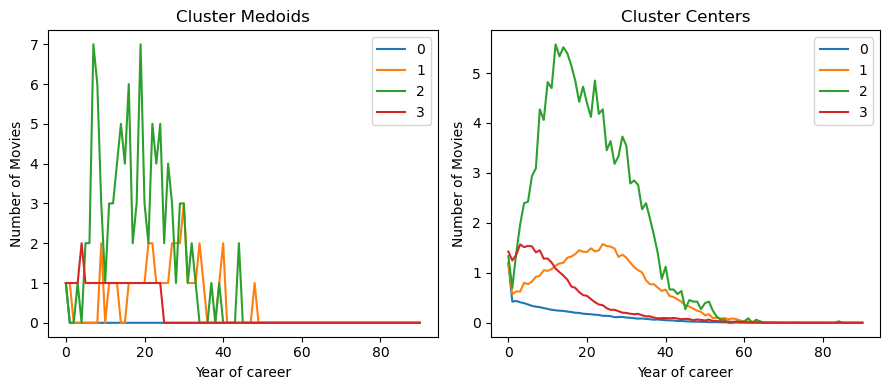

In [152]:
# Group the actors by cluster label
grouped_actors = actors_full_extensive_career.groupby('clusterLabel')

# Print the number of actors in each cluster
print(grouped_actors.size())

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate the distance between each data point and the cluster centers
distances = cdist(X, cluster_centers)

# Find the index of the data point closest to each cluster center
cluster_medoids = np.argmin(distances, axis=0)

# Get the profile sequences of the cluster medoids
medoid_profile_sequences = X[cluster_medoids]

# Plot the cluster medoids and cluster centers as subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot the cluster medoids
axs[0].plot(medoid_profile_sequences.T)
axs[0].set_xlabel('Year of career')
axs[0].set_ylabel('Number of Movies')
axs[0].set_title('Cluster Medoids')
axs[0].legend(range(n_clusters))

# Plot the cluster centers
axs[1].plot(cluster_centers.T)
axs[1].set_xlabel('Year of career')
axs[1].set_ylabel('Number of Movies')
axs[1].set_title('Cluster Centers')
axs[1].legend(range(n_clusters))

plt.tight_layout()
plt.show()

We can now observe a variety of career trajectories among actors:

1. **Prolific Long-Term Performers:** This group features a small number of actors who have a significant number of movies over a long career span, spanning almost 50 years. These individuals have sustained their presence in the movie industry across a considerable period.

2. **Ephemeral Success with Progressive Fade:** Another cluster shows actors who start their careers strongly but experience a progressive decline in approximately 20 years. This trajectory suggests an initial burst of success followed by a gradual decrease in movie engagements.

3. **Steady Career Builders:** There's a cluster of actors who take more time to build their careers. This group exhibits a gradual but steady increase in movie engagements over an extended period, showcasing a patient and persistent approach to their acting careers.

4. **Unsuccessful Career Builders:** A distinct segment is composed of actors participating in only a few movies before swiftly exiting the scene. This trajectory indicates a brief presence in the industry, with individuals opting to discontinue their acting pursuits relatively early.


#TODO: Potentiellement mieux expliquer ce markdown (c'est un peu de la chatGPT-merde)

Having uncovered these career trajectories through clustering analysis, we can further explore the patterns using Principal Component Analysis (PCA), to capture the underlying structure in the profile sequences and identify key components that contribute most significantly to the variance in actors' careers.

Explained Variance (Eigenvector 1): 0.27
Explained Variance (Eigenvector 2): 0.10
Explained Variance (Eigenvector 3): 0.05
Explained Variance (Eigenvector 4): 0.04
Explained Variance (Eigenvector 5): 0.03


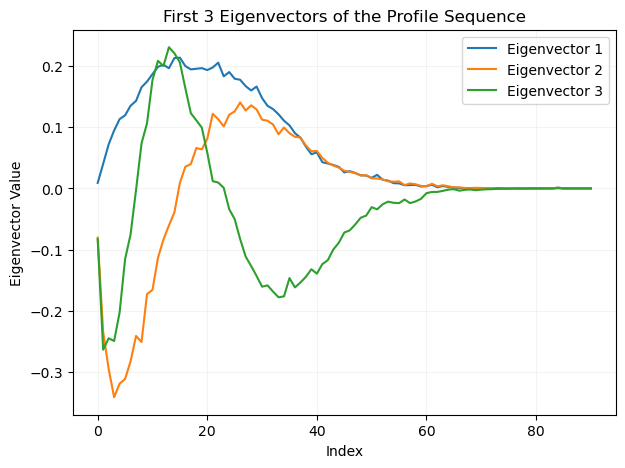

In [153]:
# Perform PCA on profile sequence
pca = PCA()
profile_sequences = actors_full_extensive_career['profileSequence'].tolist()
X = np.array(profile_sequences)
pca.fit(X)

# Get the principal components
principal_components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for the first 5 principal components
for i in range(5):
    print(f"Explained Variance (Eigenvector {i+1}): {explained_variance_ratio[i]:.2f}")

# Plot the first 3 eigenvectors of the profile sequence
plt.figure(figsize=(7, 5))

for i in range(3):
    plt.plot(principal_components[i], label=f'Eigenvector {i+1}')

plt.xlabel('Index')
plt.ylabel('Eigenvector Value')
plt.title('First 3 Eigenvectors of the Profile Sequence')
plt.legend()
plt.grid(alpha=0.15)
plt.show()

Examining the first eigenvector, which explains the highest variance (0.27), reveals significant positive weights assigned to career years 5 to 35. This suggests that this eigenvector captures a pattern where certain actors compared to others experience increased engagement and activity during this specific time frame, contributing significantly to the overall variance.

In the second eigenvector with a variance of 0.10, negative weights are noticeable in the first 15 years, followed by positive weights extending up to year 60. The third eigenvector, explaining 0.05 variance, displays very negative weights in the initial 5 years, followed by positive weights from year 5 to 25. Afterward, there's a shift to negative weights until year 60, with a notable peak around year 35. 

Additionally, it can be noted that the three eigenvectors considered are almost null for the final 30 career years. This observation aligns with the expectation, as most actors don't have such lengthy careers and, therefore, do not star in movies during this extended period.

These interpretations provide insights into the temporal patterns captured by each eigenvector and how they contribute to the overall variance in the dataset.

#TODO rewrite this and interpret

Now that we have a general understanding of the various types of career trajectories, let's delve into a more detailed analysis of more specific factors. First, we'll examine the age of actors at their first movie appearance.

The mean age at first movie appearance is 29.73 years old.
The median age at first movie appearance is 29.00 years old.
Minimum age at first movie appearance: 1.0
Maximum age at first movie appearance: 82.0


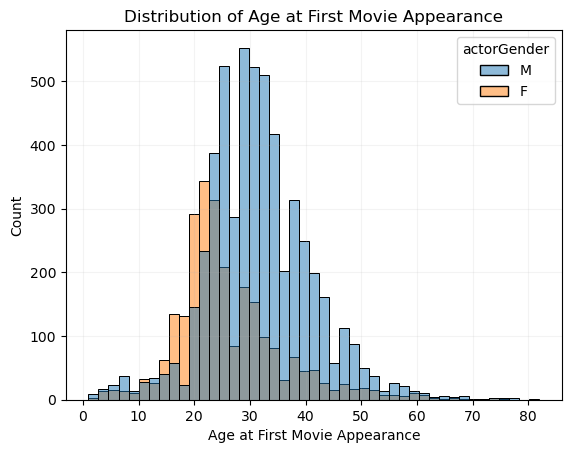

In [154]:
# Statistics on age at first movie appearance
mean_age = actors_full_extensive_career['ageAtFirstMovie'].mean()
median_age = actors_full_extensive_career['ageAtFirstMovie'].median()

print(f"The mean age at first movie appearance is {mean_age:.2f} years old.")
print(f"The median age at first movie appearance is {median_age:.2f} years old.")
print("Minimum age at first movie appearance:", actors_full_extensive_career['ageAtFirstMovie'].min())
print("Maximum age at first movie appearance:", actors_full_extensive_career['ageAtFirstMovie'].max())

# Plot histogram of age at first movie appearance
sns.histplot(data=actors_full_extensive_career, x='ageAtFirstMovie', bins=45, hue='actorGender')
plt.title("Distribution of Age at First Movie Appearance")
plt.xlabel("Age at First Movie Appearance")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

Based on the observed distributions, it appears that there is a discrepancy in the age at which individuals of different genders make their first movie appearances, with male actors seemingly starting at an older age compared to female actors. 

To formally test this observation, we can conduct a t-test with the null hypothesis that the mean age at first movie for both genders is equal, which will help confirm whether the observed difference is statistically significant or could be due to random chance.

In [155]:
men_data = actors_full_extensive_career.loc[actors_full_extensive_career['actorGender'] == 'M', 'ageAtFirstMovie']
women_data = actors_full_extensive_career.loc[actors_full_extensive_career['actorGender'] == 'F', 'ageAtFirstMovie']

# Perform the t-test
t_stat, p_value = ttest_ind(men_data.dropna(), women_data.dropna(), equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 24.15
p-value: 0.00


Given the obtained p-value that is below the statistical significance threshold, it is extremely unlikely to observe such a large difference in age at first movie appearance between men and women if there were no true difference in the population. Therefore, we may reject the null hypothesis. It can thus be suggested that the age at which male actors make their first movie appearance is statistically significantly greater than that of female actors.

The mean career length is 27.42 years.
The median career length is 27.00 years.


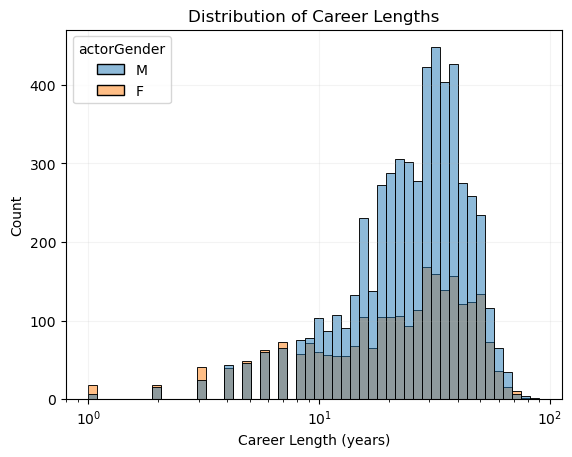

In [172]:
mean_career_length = actors_full_extensive_career["careerLength"].mean()
median_career_length = actors_full_extensive_career["careerLength"].median()

print(f"The mean career length is {mean_career_length:.2f} years.")
print(f"The median career length is {median_career_length:.2f} years.")

sns.histplot(
    data=actors_full_extensive_career[actors_full_extensive_career.careerLength != 0],
    x="careerLength",
    bins=50,
    hue="actorGender",
    log_scale=True,
)
plt.title("Distribution of Career Lengths")
plt.xlabel("Career Length (years)")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

A t-test was conducted to assess whether there is a statistically significant difference in the career lengths between male and female actors.

In [158]:
# Extract career lengths for male and female actors
male_career_lengths = actors_full_extensive_career[actors_full_extensive_career['actorGender'] == 'M']['careerLength']
female_career_lengths = actors_full_extensive_career[actors_full_extensive_career['actorGender'] == 'F']['careerLength']

# Perform the t-test
t_stat, p_value = ttest_ind(male_career_lengths.dropna(), female_career_lengths.dropna(), equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 5.23
p-value: 0.00


The p-value obtained is below the significance threshold 0.05, indicating that there is sufficent evidence to reject the null hypothesis. In other words, the observed difference in the means of career lengths between male and female actors is statistically significant. 


Moreover, we can explore the number of active years for actors throughout their career span. An active year is defined as a year in which an actor participated in a movie.

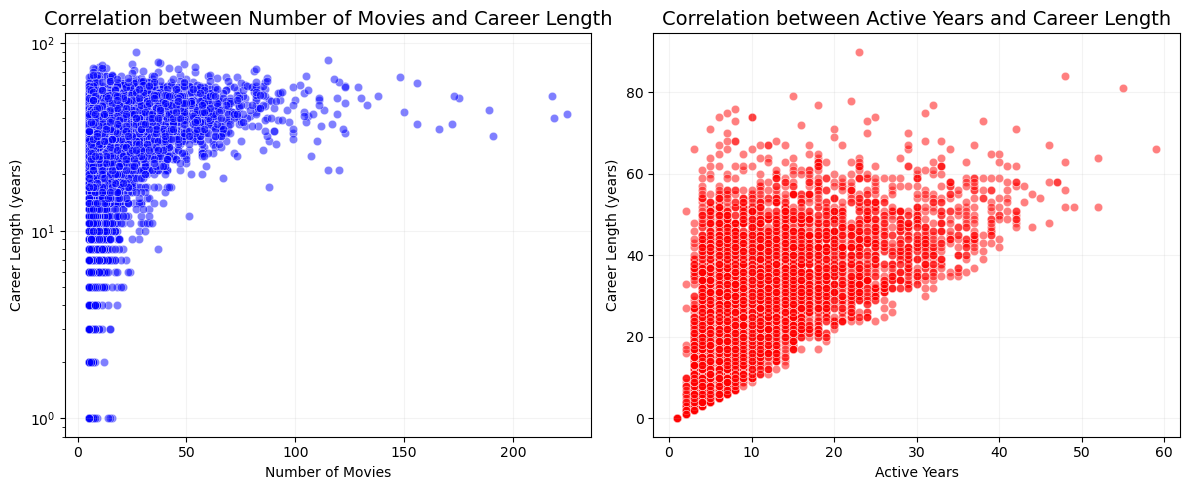

In [177]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(
    data=actors_full_extensive_career[actors_full_extensive_career.numMovies <300],
    x="numMovies",
    y="careerLength",
    ax=ax1,
    color="blue",
    alpha=0.5,
)
ax1.set_title("Correlation between Number of Movies and Career Length", fontsize=14)
ax1.set_xlabel("Number of Movies")
ax1.set_yscale("log")
ax1.set_ylabel("Career Length (years)")
ax1.grid(alpha=0.15)

# Extract unique age values from ageAtMovieRelease dictionary
actors_full_extensive_career["activeYears"] = actors_full_extensive_career[
    "ageAtMovieRelease"
].apply(lambda x: len(set(x.values())) if isinstance(x, dict) else np.nan)

sns.scatterplot(
    data=actors_full_extensive_career,
    x="activeYears",
    y="careerLength",
    ax=ax2,
    color="red",
    alpha=0.5,
)
ax2.set_title("Correlation between Active Years and Career Length", fontsize=14)
ax2.set_xlabel("Active Years")
ax2.set_ylabel("Career Length (years)")
ax2.grid(alpha=0.15)

plt.tight_layout()
plt.show()

We can observe that a significant number of actors maintain extensive careers despite being engaged in only a relatively small number of movies. There doesn't appear to be much of a correlation between career length and active years, suggesting that there is no universal trend for all actors. This is expected, as only a select few achieve notable success in their careers, reflected in a number of active years close to the career length.

In [160]:
# Calculate Pearson correlation coefficients
corr_movies_career = actors_full_extensive_career['numMovies'].corr(actors_full_extensive_career['careerLength'])
corr_active_years_career = actors_full_extensive_career['activeYears'].corr(actors_full_extensive_career['careerLength'])

print(f"Pearson Correlation (Number of Movies vs. Career Length): {corr_movies_career:.2f}")
print(f"Pearson Correlation (Active Years vs. Career Length): {corr_active_years_career:.2f}")


Pearson Correlation (Number of Movies vs. Career Length): 0.43
Pearson Correlation (Active Years vs. Career Length): 0.59


In [161]:
# Calculate the Pearson correlation coefficient between active years and career length
corr_s_l = pearsonr(actors_full_extensive_career['activeYears'], actors_full_extensive_career['careerLength'])[0]

print(f"Pearson Correlation (Active Years vs. Career Length): {corr_s_l:.2f}")

# Generate a null model (by shuffling the rows randomly, so that the relationship between 'careerLength' and 'activeYears' 
# is disrupted)
null_model = actors_full_extensive_career[['careerLength', 'activeYears']].sample(frac=1)

# Calculate the Pearson correlation coefficient for the null model
corr_null_model = pearsonr(null_model['activeYears'], null_model['careerLength'])[0]

print(f"Pearson Correlation (Null Model): {corr_null_model:.2f}")


Pearson Correlation (Active Years vs. Career Length): 0.59
Pearson Correlation (Null Model): 0.59


To validate the relationship between active years (s) and career length (L), the Pearson correlation coefficient (r) was computed. The observed correlation coefficient for actors was approximately r ≈ 0.59.

In order to assess the significance of this correlation, a null model was created by randomly sampling values of L and s from the pool of career profiles, ensuring L ≥ s. The Pearson correlation coefficient for the null model was found to be approximately r_null ≈ 0.59.

Comparing the observed correlation with the null model results, it seems that the correlation between active years and career length is not significantly different from what could be expected by random chance alone, as demonstrated by the similarity between the observed and null model correlation coefficients.

In summary, while there is a correlation between the activity (s) and career length (L) for actors, this correlation can be largely attributed to a null model. Consequently, the efficiency of actors, quantified as the ratio of active years to career length, appears to be an unpredictable quantity.


## Genres exploration

In [33]:
actors = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genresCmu": parse_list,
        "genresImdb": parse_list,
    },
)

## Cleaning `genres`

The `genresCmu` column, while having very few missing values, exhibits a wide diversity of genres, as outlined in the cell below. Additionally, the genres are not standardized; for instance, we observe distinctions like 'Action', 'Adventure' and 'Action/Adventure' making it challenging to analyze. As for `genresImdb`, we have a reasonably manageable number of unique genres. However, due to the merge, we notice a considerable number of missing values compared to `genresCmu`.

In [35]:
# Combine the genres from "genresImdb" and "genresCmu" columns into a single column
combinedGenres = movies["genresImdb"] + movies["genresCmu"]

# Assign the combined genres to a new column called "combinedGenres" in the movies dataframe
movies["combinedGenres"] = combinedGenres
movies["combinedGenres"]

0        [Drama, Mystery, Biographical film, Drama, Cri...
1                     [Crime, Drama, Crime Fiction, Drama]
2        [Horror, Mystery, Thriller, Thriller, Erotic t...
3                                           [Drama, Drama]
4        [Comedy, Short, Short Film, Silent film, Indie...
                               ...                        
81621                                                  NaN
81622    [Biography, Documentary, Drama, Biographical f...
81623                             [Comedy, Satire, Comedy]
81624                                                  NaN
81625                                                  NaN
Name: combinedGenres, Length: 81626, dtype: object

In [36]:
# Calculate the proportion of missing values in the 'genresCmu' and 'genresImdb' columns
percent_missing = movies.isnull().sum() * 100 / len(movies)
print(
    f"Proportion of missing values in each column:\n{percent_missing[['genresCmu', 'genresImdb']]}"
)

number_genres_cmu = len(movies.genresCmu.explode().unique())
number_genres_imdb = len(movies.genresImdb.explode().unique())
print("\nNumber of unique genres in\n" +
      "CMU:", number_genres_cmu, "\n"
                                 "Imdb:", number_genres_imdb)

Proportion of missing values in each column:
genresCmu      2.801803
genresImdb    37.903364
dtype: float64

Number of unique genres in
CMU: 364 
Imdb: 29


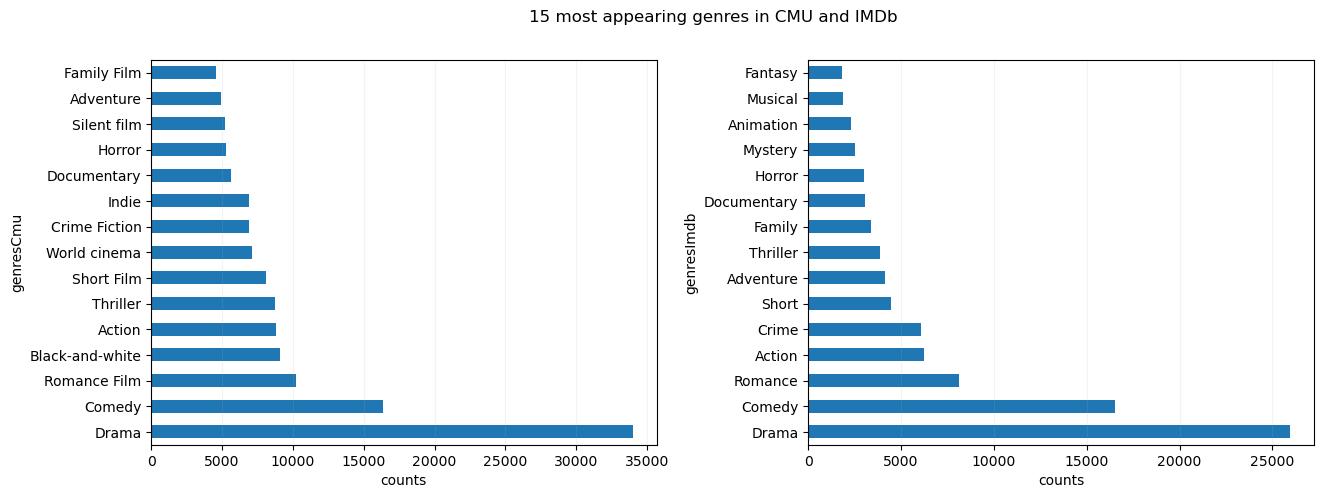

In [37]:
# Plot most common genres
fig = plt.figure(figsize=(15, 5))
fig.suptitle("15 most appearing genres in CMU and IMDb")

fig.add_subplot(121)
occurences_cmu = movies["genresCmu"].explode().value_counts()
occurences_cmu[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

fig.add_subplot(122)
occurences_imdb = movies["genresImdb"].explode().value_counts()
occurences_imdb[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")
plt.subplots_adjust(wspace=0.3)

To address the issue of numerous missing values in 'Imdb' and the diversity of genres in 'CMU', we will first combine the genres for each movie.

In [38]:
# Combine the genres from "genresImdb" and "genresCmu" columns into a single column
combinedGenres = movies["genresImdb"].apply(
    lambda x: list(x) if isinstance(x, list) else []  # Convert genresImdb to a list if it is not already
) + movies["genresCmu"].apply(
    lambda x: list(x) if isinstance(x, list) else [])  # Convert genresCmu to a list if it is not already

# Convert the combined genres into a set to remove duplicates, or set it as NaN if there are no genres
combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x) > 0 else np.nan)

# Assign the combined genres to a new column called "combinedGenres" in the movies dataframe
movies["combinedGenres"] = combinedGenres
movies["combinedGenres"]

0         {Biographical film, Mystery, Drama, Crime Drama}
1                            {Crime Fiction, Drama, Crime}
2        {Thriller, Horror, Psychological thriller, Mys...
3                                                  {Drama}
4        {Short Film, Silent film, Short, Black-and-whi...
                               ...                        
81621                                              {Drama}
81622    {Biographical film, Biography, Documentary, Dr...
81623                                     {Satire, Comedy}
81624    {Animation, Short Film, Science Fiction, Anime...
81625                    {Teen, Thriller, Horror, Slasher}
Name: combinedGenres, Length: 81626, dtype: object

Once we have a set of unique genres for each movie, the idea is to create a long string by concatenating all the genres for all the movies.

In [39]:
genres = movies.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_str = " ".join(str(g) for g in genres)

genres_unique = np.unique(genres)

Then we want to split this long string using the `split_characters` found by the code. This will, for example, allow us to split the genre 'Action/Adventure' into 'Adventure' and 'Action'. The list `words` contains all the words appearing throughout all the combinedGenres. The more a word appears in the list `words`, the more it appears in combinedGenres.

In [40]:
split_characters = set()
for letter in genres_str:
    if (
            not letter.isalpha() and letter != " "
    ):  # letter.isalpha() return True if the letter is an alphabetic string
        split_characters.add(letter)

print(split_characters)

string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))

words = string.split(" ")
print("\nThe first 15 terms of the list words", words[:15])

{'9', '/', '[', '&', '\\', '5', ']', '-', "'"}

The first 15 terms of the list words ['Biographical', 'film', 'Mystery', 'Drama', 'Crime', 'Drama', 'Crime', 'Fiction', 'Drama', 'Crime', 'Thriller', 'Horror', 'Psychological', 'thriller', 'Mystery']


Now, our objective is to identify the most frequently occurring words in our list of `words`. As one can observe above, some words are presented in uppercase, while others are in lowercase. To ensure consistency, we convert all text to lowercase and proceed to identify words that appear more than 2000 times. 

In [41]:
words = list(map(lambda x: x.lower(), words))

counts = pd.Series(words).value_counts()
new_genres_serie = pd.Series(counts[counts > 2000])
new_genres_serie.index

Index(['drama', 'film', 'comedy', 'romance', 'action', 'crime', 'thriller',
       'short', 'adventure', 'fiction', 'family', 'black', 'and', 'white',
       'cinema', 'world', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', '', 'fantasy', 'mystery', 'movies', 'animation',
       'war', 'science', 'western', 'movie', 'biography', 'japanese', 'music',
       'history'],
      dtype='object')

Finally, we have a list of words representing our new genres. After filtering out words that do not correspond to actual genres, we create a dictionary, `genres_dict`, linking genres from 'CMU' and 'IMDb' to our new list of genres. For example, all genres containing the word 'drama' will be associated with the genre 'Drama.' 

A list of genres associated with 'Drama' is displayed two cells below.

In [42]:
# Dropping irrelevant genres and characters from the series
new_genres_serie = new_genres_serie.drop(
    index=[
        "",
        "film",
        "cinema",
        "movie",
        "movies",
        "black",
        "and",
        "white",  # combining "black-and-white" instead of having separate entries
    ]
)

# Adding "black-and-white" to the indices
new_genres_serie["black-and-white"] = 0

# Capitalizing the new genres and create a list from the indices
new_genres = list(map(lambda x: x.capitalize(), new_genres_serie.index))

genres_dict = {genre: set() for genre in new_genres}
for new_genre in new_genres:
    for genre in genres_unique:
        if new_genre.lower() in genre.lower():
            genres_dict[new_genre].add(genre)

# Merging "Romantic" into "Romance" since can be considered equivalent
genres_dict["Romance"] = genres_dict["Romance"].union(genres_dict.pop("Romantic"))
new_genres.remove("Romantic")

# Merging "Music" into "Musical" since can be considered equivalent
genres_dict["Musical"] = genres_dict["Music"].union(genres_dict.pop("Music"))
new_genres.remove("Music")

print(len(new_genres), "unified genres listed below")
new_genres

26 unified genres listed below


['Drama',
 'Comedy',
 'Romance',
 'Action',
 'Crime',
 'Thriller',
 'Short',
 'Adventure',
 'Fiction',
 'Family',
 'World',
 'Indie',
 'Horror',
 'Documentary',
 'Silent',
 'Musical',
 'Fantasy',
 'Mystery',
 'Animation',
 'War',
 'Science',
 'Western',
 'Biography',
 'Japanese',
 'History',
 'Black-and-white']

In [43]:
genres_dict["Drama"]

{'Addiction Drama',
 'Childhood Drama',
 'Comedy-drama',
 'Costume drama',
 'Courtroom Drama',
 'Crime Drama',
 'Docudrama',
 'Drama',
 'Erotic Drama',
 'Family Drama',
 'Fantasy Drama',
 'Historical drama',
 'Inspirational Drama',
 'Legal drama',
 'Marriage Drama',
 'Melodrama',
 'Musical Drama',
 'Political drama',
 'Romantic drama'}

In conclusion to the cleaning process, we apply the function `unify_genres()` to our column combinedGenres, creating the new unique column genres. This transformation ensures that the genres are now meaningful for our analysis

In [44]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in new_genres if genre in genres_dict[t]}
            unified_genres = unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError:
        return x


movies["genres"] = movies["combinedGenres"].apply(unify_genres)

## Genre Distribution in our Dataset

Prior to investigating how actors evolve across various genres, let's first examine the distribution of genres within our dataset. We begin by looking at the occurrence of genres after the cleaning process.

Proportion of missing values in column genres: 3.16%


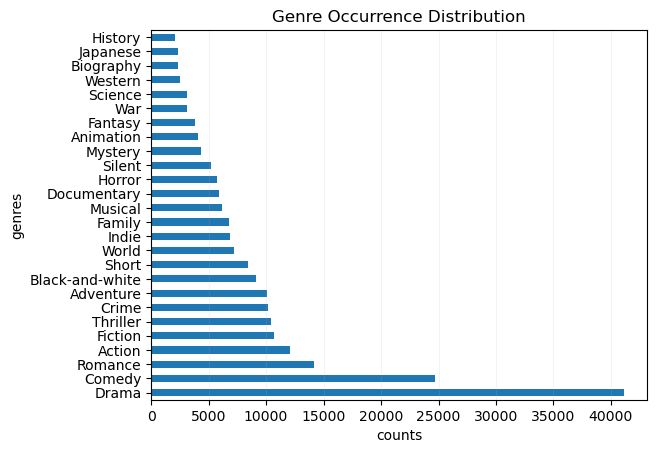

In [45]:
occurences = movies["genres"].explode().value_counts()
occurences.plot(kind="barh")
plt.title("Genre Occurrence Distribution")
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

percent_missing = movies["genres"].isnull().sum() / len(movies)
print(f"Proportion of missing values in column genres: {percent_missing:.2%}")

Let's also examine the evolution of genres popularity over the years.

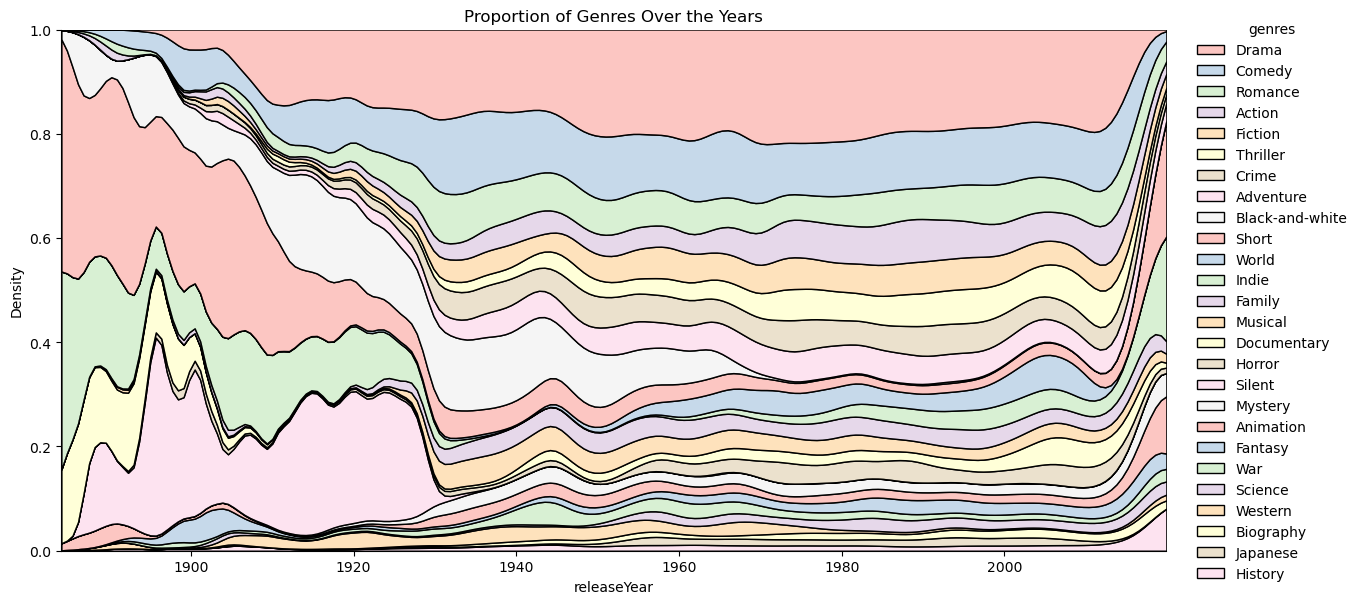

In [46]:
# Extracting relevant columns and exploding the 'genres' column for analysis
data = movies[["releaseYear", "genres"]].explode("genres").reset_index()

# Generating a color palette for distinct genres
palette = sns.color_palette("Pastel1", n_colors=len(data["genres"].unique()))

# Creating a kernel density estimate (kde) plot to visualize genre distribution over release years
sns.displot(
    data,
    x="releaseYear",
    hue="genres",
    kind="kde",
    multiple="fill",
    bw_adjust=0.5,
    hue_order=movies.genres.explode().dropna().value_counts().index.tolist(),
    palette=palette,
    aspect=2,
    height=6,
)
plt.title("Proportion of Genres Over the Years")
plt.show()

This visualization effectively captures the decline of silent movies (pale rose) around 1930 and the diminishing presence of black-and-white films (light gray) in the 70s. Regarding other genres, it appears that certain genres enjoyed greater popularity during specific eras. A notable example is the Western genre, which seems to have been more popular before the 1980s. However, it's crucial to approach this plot with caution, considering that the number of movies in our dataset is not evenly distributed across the years. This imbalance is evident in the figure below.

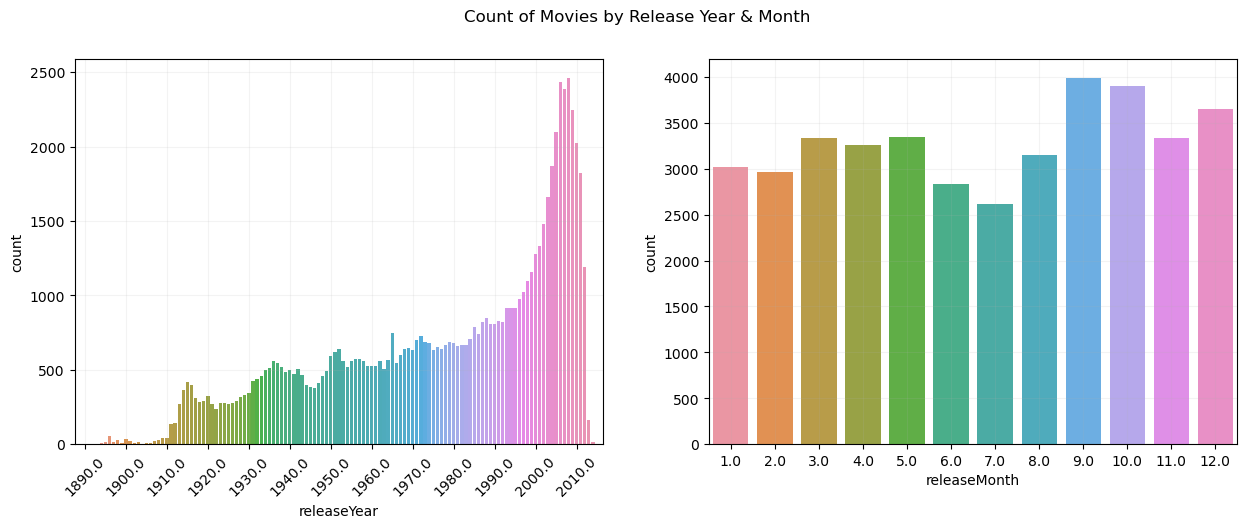

In [47]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Count of Movies by Release Year & Month')

# Subplot 1: Movie count by release year
fig.add_subplot(121)
sns.countplot(x='releaseYear', data=movies)
plt.xticks(plt.xticks()[0][2::10], rotation=45)
plt.grid(alpha=0.15)

# Subplot 2: Movie count by release month
fig.add_subplot(122)
sns.countplot(x="releaseMonth", data=movies)
plt.grid(alpha=0.15)

plt.subplots_adjust(wspace=0.2)  # Adjusting subplot spacing
plt.show()

Analyzing movie genres poses a challenge because movies often belong to multiple genres as one can observe below.

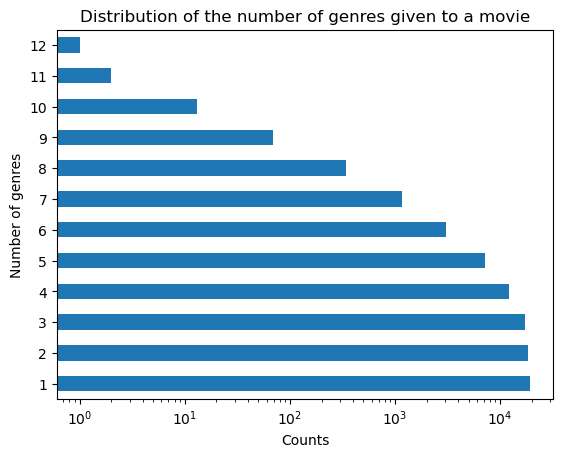

In [48]:
movies["genres"].dropna().apply(lambda x: len(x)).value_counts().plot(kind="barh")
plt.title("Distribution of the number of genres given to a movie")
plt.ylabel("Number of genres")
plt.xlabel("Counts")
plt.xscale("log")

To gain a deeper insight into this phenomenon within our dataset and identify the genres with the most overlap, we generate a heatmap as shown in the figure below. Each row in the genre heatmap displays the probability of being associated with another genre, indicated by the corresponding column. The diagonal represents the probability of a genre appearing on its own.

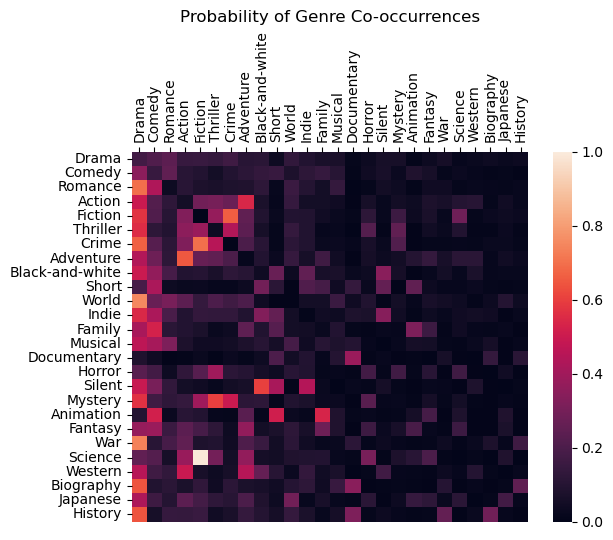

In [49]:
# Explode the genres and get dummies
genre_dummies = pd.get_dummies(movies["genres"].explode())
genre_dummies.index.name = "index"
genre_dummies_grouped = genre_dummies.groupby("index").sum()

# Get ordered list of genres
genres_list = movies["genres"].explode().dropna().value_counts().index.to_list()

# Calculate co-occurrences
co_occurrences_matrix = np.zeros((len(genres_list), len(genres_list)))
for x, genre_x in enumerate(genres_list):
    for y, genre_y in enumerate(genres_list):
        if genre_x == genre_y:
            co_occurrences_matrix[x, y] = (
                    movies["genres"].apply(lambda x: x == {genre_x}).sum()
                    / genre_dummies_grouped[genre_x].sum()
            )
        else:
            co_occurrences_matrix[x, y] = ((genre_dummies_grouped[genre_x] + genre_dummies_grouped[
                genre_y]) == 2).sum() / genre_dummies_grouped[genre_x].sum()

# Plot heatmap
heatmap_ax = sns.heatmap(
    co_occurrences_matrix,
    xticklabels=genres_list,
    yticklabels=genres_list,
    vmax=1,
    vmin=0,
)

# Move x-axis to top and rotate labels
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90)

# Set title
plt.title("Probability of Genre Co-occurrences");

It's not surprising to observe that the "Science" genre is consistently associated with "Fiction" in our dataset, given that Science Fiction movies are inherently a combination of both elements. However, the relationship is not reciprocal for "Fiction" which exhibits a higher probability of being paired with "Crime" than with "Science". Additionally, genres rarely stand alone, with the exception of "Documentary", which appears independently about 50% of the time. Another noteworthy observation is that genres appearing in the same years tend to have a higher probability of co-occurrence, as seen in the case of 'Silent' and 'Black-and-White.'

This plot is crucial for our analysis as it provides insights into the relationships between genres, helping us understand trends influenced by these overlaps.

## Actors and Genres

First, let's examine the gender distribution within each genre, keeping in mind that the average proportion of women in our dataset is 34%.

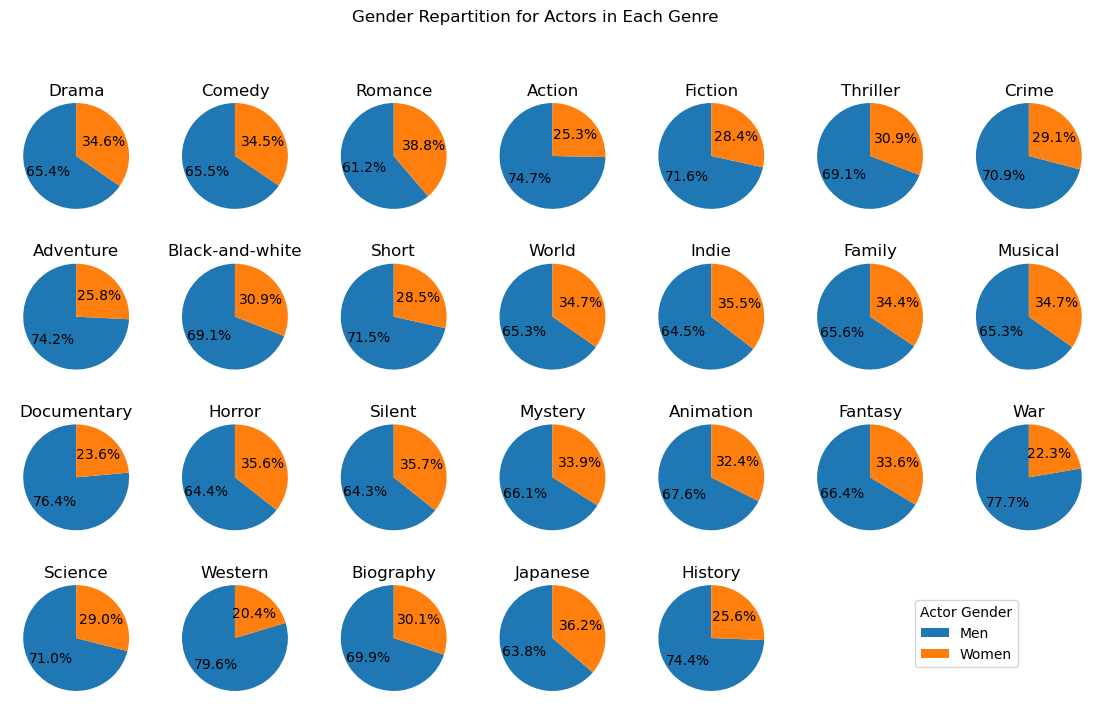

In [50]:
# Exploding actors dataset on movies and merging with movie genres
actors_exploded = explode_on_movies(actors)
merged_actors_genres = actors_exploded.merge(
    movies[["fbID", "genres"]], how="left", on="fbID"
)

# Exploding the merged dataset on genres
exploded_actors_genres = merged_actors_genres.explode("genres")

# Pie charts for each genre
fig, axes = plt.subplots(4, 7, figsize=(14, 8))
for genre, ax in zip(genres_list, axes.ravel()):
    genders = exploded_actors_genres[exploded_actors_genres["genres"] == genre][
        "actorGender"
    ].value_counts()
    patches, _, _ = ax.pie(genders, startangle=90, autopct="%1.1f%%")
    ax.set_title(genre, y=0.9)

# Removing unnecessary subplots
axes[3, 5].axis("off")
axes[3, 6].axis("off")

# Setting overall title and legend
fig.suptitle("Gender Repartition for Actors in Each Genre")
fig.legend(
    patches, labels=["Men", "Women"], title="Actor Gender", bbox_to_anchor=(0.85, 0.25)
)

The proportion of female actors varies significantly across different genres. The highest proportion is found in Romance, while the lowest is observed in Western films.

In the following cell, our objective is to analyze whether the proportion of an actor's roles in a particular genre correlates with the proportion of movies they have played in another genre. To achieve this, we begin by grouping all the movies associated with each actor, keeping track of the genre count for each. This count is then normalized by dividing it by the total number of movies in which the actor performed. As a result, for each actor, we obtain a vector representing the frequency of unique genres, as illustrated below.

In [51]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "numMovies", "genres"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Grouping by actor and summing genre counts
actor_genre_counts = (
    (1 * genre_dummies)
    .groupby("fbActorID")
    .agg({"numMovies": lambda x: x.mean(), **dict.fromkeys(genres_list, sum)})
)

# Filtering actors with at least 50 movies to get meaningfull genres proportions
actor_genre_counts = actor_genre_counts.query("numMovies >= 50")

# Calculating genre proportions for each actor
actor_genre_proportion = actor_genre_counts[genres_list].div(
    actor_genre_counts["numMovies"], axis=0
)

print("Number of actors kept to evaluate correlation:", len(actor_genre_proportion))

actor_genre_proportion

Number of actors kept to evaluate correlation: 654


,Drama,Comedy,Romance,Action,Fiction,Thriller,Crime,Adventure,Black-and-white,Short,...,Silent,Mystery,Animation,Fantasy,War,Science,Western,Biography,Japanese,History
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.807692,0.134615,0.230769,0.423077,0.230769,0.192308,0.230769,0.538462,0.000000,0.000000,...,0.000000,0.057692,0.038462,0.076923,0.192308,0.038462,0.153846,0.057692,0.000000,0.076923
/m/011_r9,0.714286,0.339286,0.500000,0.071429,0.125000,0.089286,0.142857,0.107143,0.535714,0.035714,...,0.214286,0.071429,0.000000,0.053571,0.017857,0.017857,0.035714,0.017857,0.000000,0.035714
/m/011xjd,0.365079,0.126984,0.142857,0.301587,0.206349,0.158730,0.190476,0.365079,0.380952,0.000000,...,0.015873,0.190476,0.000000,0.158730,0.047619,0.063492,0.285714,0.015873,0.000000,0.015873
/m/01200d,0.709302,0.325581,0.302326,0.197674,0.104651,0.023256,0.116279,0.186047,0.616279,0.069767,...,0.348837,0.023256,0.000000,0.023256,0.139535,0.023256,0.186047,0.023256,0.000000,0.034884
/m/012c6j,0.671875,0.640625,0.625000,0.031250,0.031250,0.046875,0.093750,0.093750,0.531250,0.031250,...,0.265625,0.015625,0.000000,0.031250,0.031250,0.000000,0.015625,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0q9kd,0.438356,0.835616,0.328767,0.178082,0.273973,0.164384,0.315068,0.219178,0.000000,0.013699,...,0.000000,0.054795,0.054795,0.136986,0.013699,0.041096,0.013699,0.027397,0.013699,0.000000
/m/0tj9,0.756614,0.296296,0.349206,0.449735,0.116402,0.153439,0.164021,0.195767,0.000000,0.005291,...,0.000000,0.031746,0.000000,0.042328,0.015873,0.005291,0.005291,0.005291,0.000000,0.015873
/m/0ywqc,0.684685,0.306306,0.135135,0.288288,0.306306,0.405405,0.279279,0.243243,0.000000,0.009009,...,0.000000,0.153153,0.018018,0.054054,0.135135,0.099099,0.018018,0.063063,0.027027,0.054054


For every pair of columns (genres) in our dataframe, we assess the correlation between them. The outcomes are displayed above. If the p-value of the Pearson correlation coefficient exceeds 0.05, we cannot dismiss the null hypothesis that the columns are uncorrelated. The results are therefore depicted in the heatmap below only when the p-value is less than the significance level of 0.05.

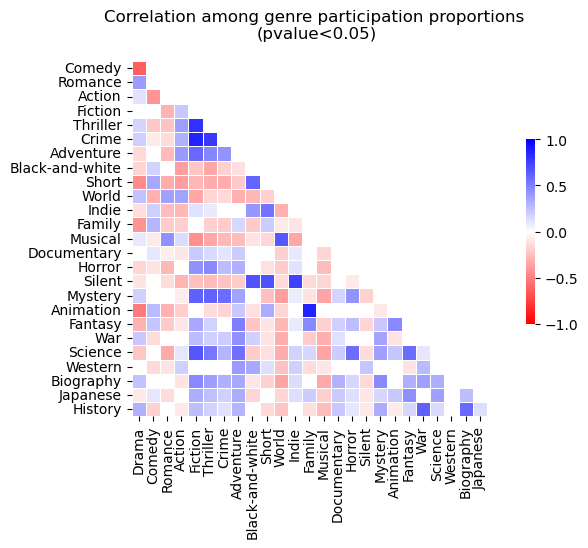

In [52]:
# Calculating Pearson correlation coefficients and p-values for genre proportions
pvalues = np.zeros((len(genres_list), len(genres_list)))
cor = np.zeros((len(genres_list), len(genres_list)))
for i, genre_i in enumerate(genres_list):
    for j, genre_j in enumerate(genres_list):
        cor[i, j], pvalues[i, j] = pearsonr(
            actor_genre_proportion[genre_i], actor_genre_proportion[genre_j]
        )

# Diverging color map for correlation visualization
divnorm = colors.CenteredNorm(vcenter=0, halfrange=np.max(np.abs(cor)))

# Mask for statistically insignificant correlations (p >= 0.05)
mask = np.triu(np.ones_like(cor, dtype=bool))
mask = mask + (pvalues >= 0.05) * 1

sns.heatmap(
    cor,
    yticklabels=genres_list,
    xticklabels=genres_list,
    cmap="bwr_r",
    norm=divnorm,
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.xticks(plt.xticks()[0][:-1])
plt.yticks(plt.yticks()[0][1:])
plt.title("Correlation among genre participation proportions \n(pvalue<0.05)");

The interpretation of the results should consider the earlier findings on movie co-occurrence. For instance, a high correlation between 'Crime' and 'Fiction' may stem from two possibilities:

1. Actors who appear in crime movies indeed have a higher likelihood of also participating in fiction.
2. All the crime movies featuring certain actors were simultaneously labeled as fiction, and vice versa.

In the second scenario, no definitive conclusion can be drawn about the correlation between the genre proportions of actors. However, in the case of a negative correlation, this could be attributed not only to movies lacking these shared genres but also to a nuanced influence on actors. Consider, for example, the genres of comedy and drama. While our co-occurrence matrix suggests a 30% probability of a comedy also being a drama, from an actor's perspective, playing roles in either genre seems to negatively influence the chances of participating in the other.

Moreover, regarding drama movies, although many genres show a high likelihood of association with drama based on the co-occurrence matrix, positive correlation is not always observed when viewed from an actor's standpoint.

To further explore the trajectory of actors across genres, we will be constructing a Markov Chain in the following manner for milestone 3:

> Each state within the chain will symbolize a distinct genre, while the edges will indicate the probabilities of transitioning from one genre to another.

Our objective is to see the typical types of movies actors tend to embrace after participating in a specific genre. This exploration will provide insights into whether certain actors tend to remain within a given genre or explore diverse genres. Moreover, we aim to investigate whether such tendencies vary depending on the age of the actors. To achieve this, we will develop two Markov chains - one for young actors and another for older ones - and analyze the potential differences in their genre-transition tendencies.

## Oscar-Winning Actors Network

In [53]:
actors_exploded = explode_on_movies(actors)

### Filtering actors who won an Oscar

In [54]:
# Filter the DataFrame to include only actors who won an Oscar
winner_actors_ID = actors_exploded[actors_exploded["winner"] == True]["fbActorID"].to_list()

In [55]:
winner_actors_exp = actors_exploded.loc[
    actors_exploded["fbActorID"].isin(winner_actors_ID)
]

In [56]:
winner_actors_exp['actorDOB'] = pd.to_datetime(winner_actors_exp['actorDOB']).dt.year

In [57]:
winner_actors = winner_actors_exp.groupby(
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
    ],
    dropna=False
).apply(actors_agg).reset_index().set_index("actorName")

# Generate the network

Create a graph where actors are represented as nodes, and edges signify collaboration through shared appearances in the same movies. The weight of each edge corresponds to the number of movies in which the respective actors have worked together.

In [58]:
actorNames = winner_actors.index
actorMovies = winner_actors["fbID"]

In [59]:
G = nx.Graph()
edge_attribute_dict = {}

In [60]:
movies_IDs = movies["fbID"].to_list()

In [61]:
for actor_name_x, movie_ids_x in tqdm(zip(actorNames, actorMovies), total=len(actorNames),
                                      desc='Building network graph'):
    G.add_node(actor_name_x)
    for movie_id in movie_ids_x:
        if movie_id in movies_IDs:
            for actor_name_y, movie_ids_y in zip(actorNames, actorMovies):
                if (movie_id in movie_ids_y) and (actor_name_x != actor_name_y):
                    G.add_edge(actor_name_x, actor_name_y)
                    edge_name = tuple(sorted((actor_name_x, actor_name_y)))
                    if edge_name not in edge_attribute_dict:
                        edge_attribute_dict[edge_name] = 1
                    else:
                        edge_attribute_dict[edge_name] += 1

Building network graph:   1%|          | 2/268 [00:00<00:18, 14.53it/s]

Building network graph: 100%|██████████| 268/268 [00:10<00:00, 24.62it/s]


In [62]:
# Set edge attribute to represent the weight, corresponding to the number of movies the two related actors did together
for k, v in edge_attribute_dict.items():
    edge_attribute_dict[k] = {"weight": v}

nx.set_edge_attributes(G, edge_attribute_dict)

In [63]:
# Define generation ranges
generation_ranges = {
    'The Missionary Generation': (1860, 1882),
    'The Lost Generation': (1883, 1900),
    'The Greatest Generation': (1901, 1927),
    'The Silent Generation': (1928, 1945),
    'The Baby Boomer Generation': (1946, 1964),
    'Generation X': (1965, 1980),
    'Millennials': (1981, 1996),
    'Generation Z': (1997, 2012),
    'Gen Alpha': (2013, 2025)
}

# Create a new column with the generation labels
winner_actors['actorGeneration'] = pd.cut(winner_actors['actorDOB'],
                                          bins=[start - 1 for _, (start, _) in generation_ranges.items()] + [
                                              max(end for _, (_, end) in generation_ranges.items()) + 1],
                                          labels=list(generation_ranges.keys()))

In [64]:
# add node attributes by passing dictionary of type name -> attribute
nx.set_node_attributes(G, winner_actors['actorGender'].to_dict(), 'actorGender')
nx.set_node_attributes(G, winner_actors['actorDOB'].to_dict(), 'actorDOB')
nx.set_node_attributes(G, winner_actors['actorEthnicity'].to_dict(), 'actorEthnicity')

# Network analysis

In [65]:
describe_graph(G)

Graph with 268 nodes and 3183 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0890
Global clustering coefficient aka Transitivity: 0.2279


The graph is not connected, meaning there are isolated components within it. This suggests that there are groups of actors who have not collaborated in any films with actors outside their respective groups.

The sparsity of the graph, indicating that the ratio of actual edges to the maximum possible edges is relatively low. This is typical in social networks or collaboration graphs where not every pair of nodes (actors) has worked together.

The global clustering coefficient measures the degree to which nodes in the graph tend to cluster together. A higher coefficient suggests that actors who have worked together are likely to have other collaborators in common. The value we obtain indicates a moderate level of clustering.

To get a vibe of the network, let's kick things off with a visual inspection of the graph.

# How connected is the Oscar-winning actors network ?

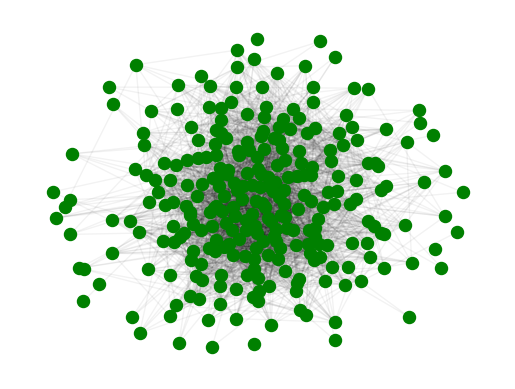

In [66]:
visualize_graph(G, False, k=1, alpha=0.05, node_shape='.')

It's not exactly a sight for sore eyes (We Gephi for more visually appealing plots). Nevertheless, a couple of interesting observations pop out:

- The graph isn't one big happy family; there are some isolated actors.
- Certain nodes seem to have loads of connections, they are hubs.

So, let's have a look at graph but this time generated in Gephi:

![graph.png](Data/Images/graph.png)

The nodes' sizes corresponds to the number of connections, and the edge thickness corresponds to how frequently two actors shared the screen. This allows us to identify patterns among the Oscar-winning actors. Certain actor pairs or groups form robust connections, others stand out with an abundance of connections.

# Connected Components

In [67]:
comp = list(nx.connected_components(G))
print(f'The graph contains {len(comp)} connected components')

The graph contains 5 connected components


In [68]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp) / G.number_of_nodes()
print(f'The largest component has {len(largest_comp)} nodes, accounting for {percentage_lcc:.2%} of the nodes')

The largest component has 264 nodes, accounting for 98.51% of the nodes


From visually inspecting the graph, we already saw that most of the nodes are in the largest component: the giant component.

Let's have a look at the other components?

In [69]:
comp[1:]

[{'Prince'}, {'Pete Docter'}, {'Herbie Hancock'}, {'Chris Landreth'}]

The other components are are actually isolated individuals. The other components are individuals. 

# Diameter and Shortest Paths

Suppose I want to find the shortest path between two Oscar-winning actors, for example, what would be the path to connect Julia Roberts to Yul Brynner?

![Julia Roberts.jpeg](Data/Images/Julia%20Roberts.jpeg)
![Yul Brynner.JPG](Data/Images/Yul%20Brynner.JPG)

In [70]:
Bridges_Cage_path = nx.shortest_path(G, source="Julia Roberts", target="Yul Brynner")
print(f'Shortest path between Jeff Bridges and Nicolas Cage {Bridges_Cage_path}')

Shortest path between Jeff Bridges and Nicolas Cage ['Julia Roberts', 'Linda Hunt', 'James Coburn', 'Yul Brynner']


In [71]:
# Take the largest component and analyse its diameter = longest shortest-path
lcc_G = G.subgraph(largest_comp)
print(f'The diameter of the largest connected component is {nx.diameter(lcc_G)}')
print(
    f'The average shortest path length of the largest connected component is {nx.average_shortest_path_length(lcc_G):.2f}')

The diameter of the largest connected component is 5
The average shortest path length of the largest connected component is 2.23


The diameter of the largest connected component in the graph of Oscar-winning actors is 5, indicating the maximum distance between any pair of actors within this connected component. The average shortest path length within this component is approximately 2, suggesting a relatively short average distance between actors in terms of collaborations in shared movies. 

# A friend of my friend is my friend

We employ a global measure called transitivity (aka global clustering coefficient), or the ratio of all existing triangles (closed triples) over all possible triangles (open and closed triplets).

In [72]:
print(f'Network transitivity: {nx.transitivity(G):.4f}')

Network transitivity: 0.2279


We employ a local measure called clustering coefficient, which quantifies for a node how close its neighbours are to being a clique (complete graph). Measured as the ratio of, the number of edges to the number of all possible edges, among the neighbors of a node.

In [73]:
# Similar measure but for individual nodes called clustering coefficient
print(f'Clustering coefficient for actor "Tommy Lee Jones": {nx.clustering(G, "Tommy Lee Jones"):.4f}')

Clustering coefficient for actor "Tommy Lee Jones": 0.1832


In [74]:
# Let's check by looking at the subgraph induced by Tommy Lee Jones
subgraph = G.subgraph(['Tommy Lee Jones'] + list(G.neighbors('Tommy Lee Jones')))

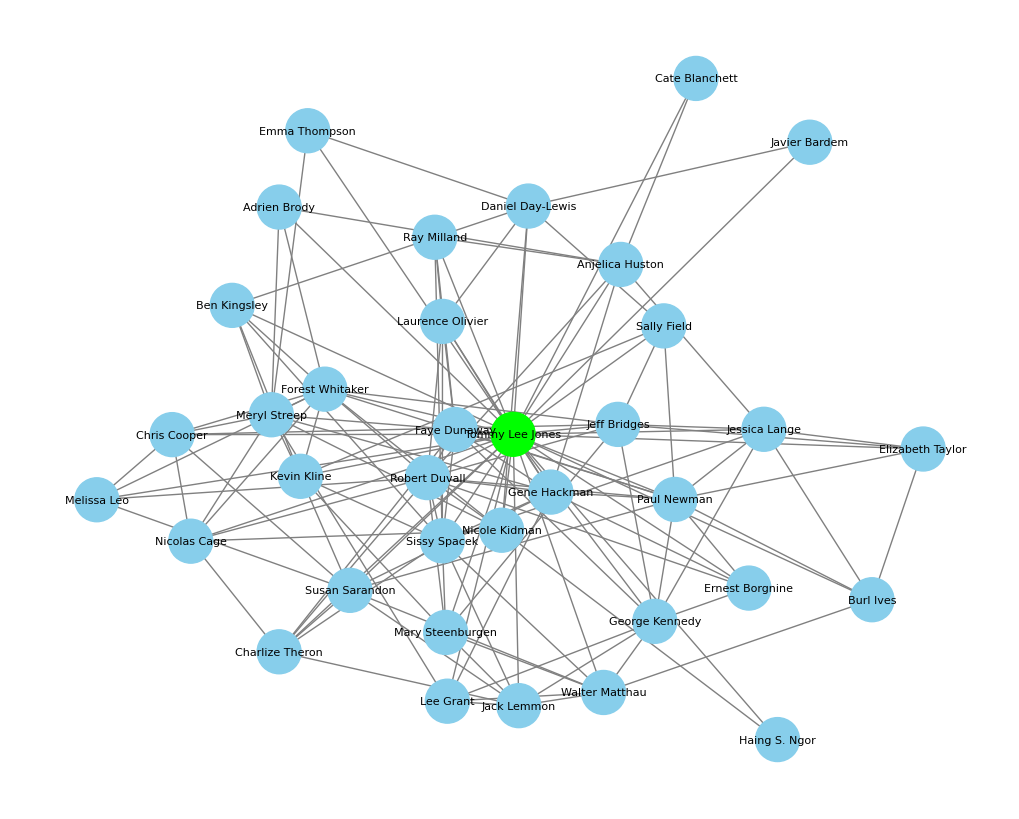

In [75]:
plt.figure(figsize=(10, 8))
# Set the color for the 'Tommy Lee Jones' node
node_colors = ['skyblue' if node != 'Tommy Lee Jones' else 'lime' for node in subgraph.nodes()]

nx.draw(subgraph, with_labels=True, node_color=node_colors, node_size=1000, edge_color='grey', linewidths=1,
        font_size=8, font_color='black', node_shape='o')

# Which actors are the most important ?

The response boils down to... it depends. Numerous methods exist for identifying crucial nodes in a graph, such as assessing:

- Degree
- Betweenness centrality
- ...

**Degree: the more people you know, the more important you are!**

In [76]:
degrees = dict(G.degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular actors are.. 
for actor, degree in sorted_degree[:5]:
    print(f'{actor} knows {degree} people')

Gene Hackman knows 60 people
Michael Caine knows 59 people
Charlton Heston knows 56 people
Henry Fonda knows 55 people
Robert Duvall knows 55 people


Now, let's delve into the examination of the degree distribution. It becomes evident that the majority of Oscar-winning actors are linked to numerous other Oscar-winning actors, and a few stand out as exceptionally popular within the network.

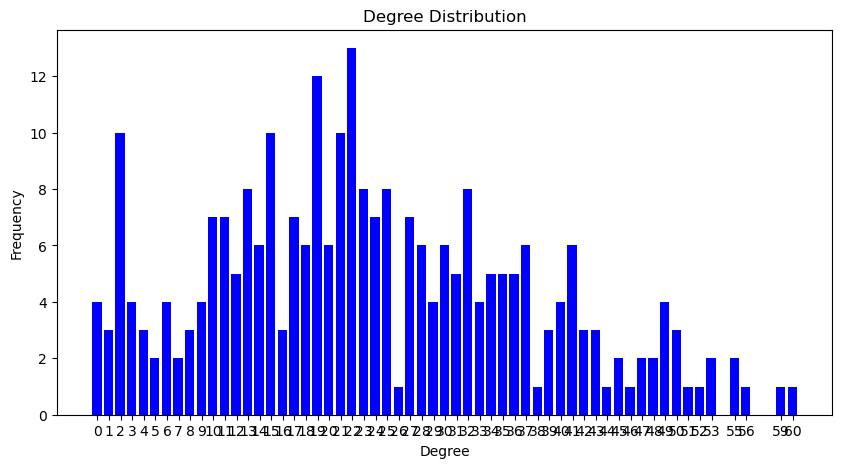

In [77]:
# bar plot
plot_degree_distribution(G)

**Betweeness centrality: the more shortest paths pass through a node, the more important it is!**

Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

In [78]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(G, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for actor, bw in sorted_betweenness[:5]:
    print(f'{actor} has betweeness: {bw:.3f}')

Michael Caine has betweeness: 0.028
Charlton Heston has betweeness: 0.024
Shirley MacLaine has betweeness: 0.022
Paul Newman has betweeness: 0.021
Gene Hackman has betweeness: 0.020


Time to examine the betweenness centrality across all nodes in the network. It's notable that a handful of nodes have relatively high betweenness centrality, and the majority exhibit lower values. The node with the lowest degree is the one with the highest betweeness centrality.

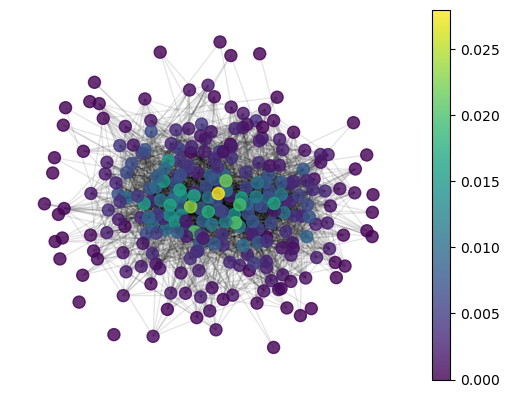

In [79]:
# similar pattern
list_nodes =list(G.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(G, k=1)
ec = nx.draw_networkx_edges(G, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=list_nodes, node_color=[G.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

# Communities

Community detection is a common class of methods applied to graphs. 

This is how it works: Edges possessing high betweeness centrality separate communities. The algorithm starts with the entire graph and then it iteratively removes the edge with the highest betweeness.

Here we can calculate “modularity” in Gephi:

![community.png](Data/Images/communitypng.png)

Let's get a closer look at this!

Here's how it appears when we assign node colors based on the actor's generation, outlined as follows:

- The Missionary Generation (1860-1882): (1860, 1882)
- The Lost Generation (1883-1900): (1883, 1900)
- The Greatest Generation (1901-1927): (1901, 1927)
- The Silent Generation (1928-1945): (1928, 1945)
- The Baby Boomer Generation (1946-1964): (1946, 1964)
- Generation X (1965-1980): (1965, 1980)
- Millennials (1981-1996): (1981, 1996)
- Generation Z (1997-2012): (1997, 2012)
- Gen Alpha (2013-2025): (2013, 2025)

Darker colors are indicative of older generations. It's intriguing to note a resemblance between the communities we generated and the various generations. However, there are also noticeable connections bridging different generations.

![generations.png](Data/Images/generations.png)

## Ethnicities

Number of ethnicities: 250


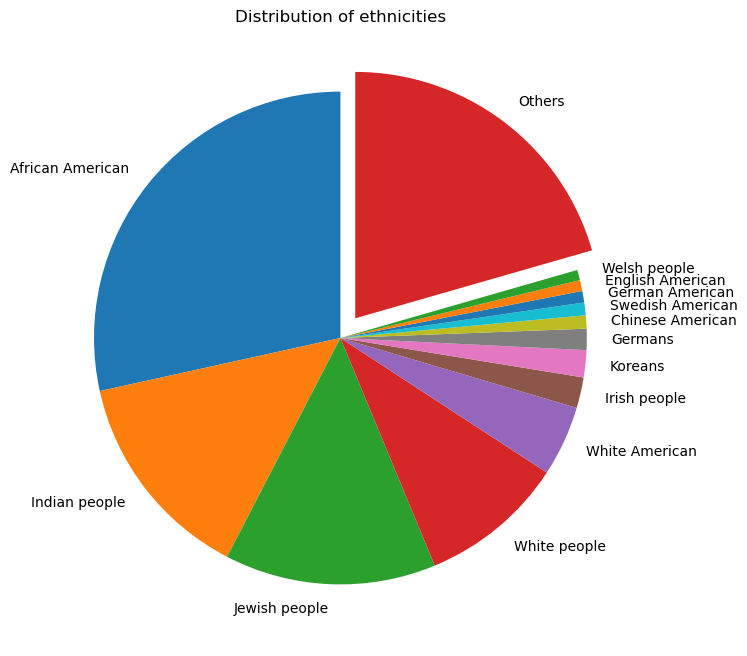

In [80]:
print("Number of ethnicities:", len(actors_load["actorEthnicity"].unique()))

string_counts = actors_load["actorEthnicity"].value_counts()

threshold = 35
string_counts['Others'] = string_counts[string_counts < threshold].sum()
string_counts = string_counts[string_counts >= threshold]

explode = [0.1 if label == 'Others' else 0 for label in string_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(string_counts, labels=string_counts.index, startangle=90, explode=explode)
plt.title("Distribution of ethnicities")
plt.show()

Many different ethnicities are represented in the dataset. Most of them are really specific and concern only a few actors. In the pie chart, the ethnicities possessed by less than 18 actors are represented together in the category `Others`. The threshold is chosen to allow a good visualization.

It is important to note that these labels are likely biased: the categories "White people" and "White American" are probably highy under-represented. It could be due to a bias from the people labelling the data who might be more likely to forget to add an ethnicity value for these people.

## Analysis of the Oscars

In [87]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genresCmu": parse_list,
        "genresImdb": parse_list,
    },
)

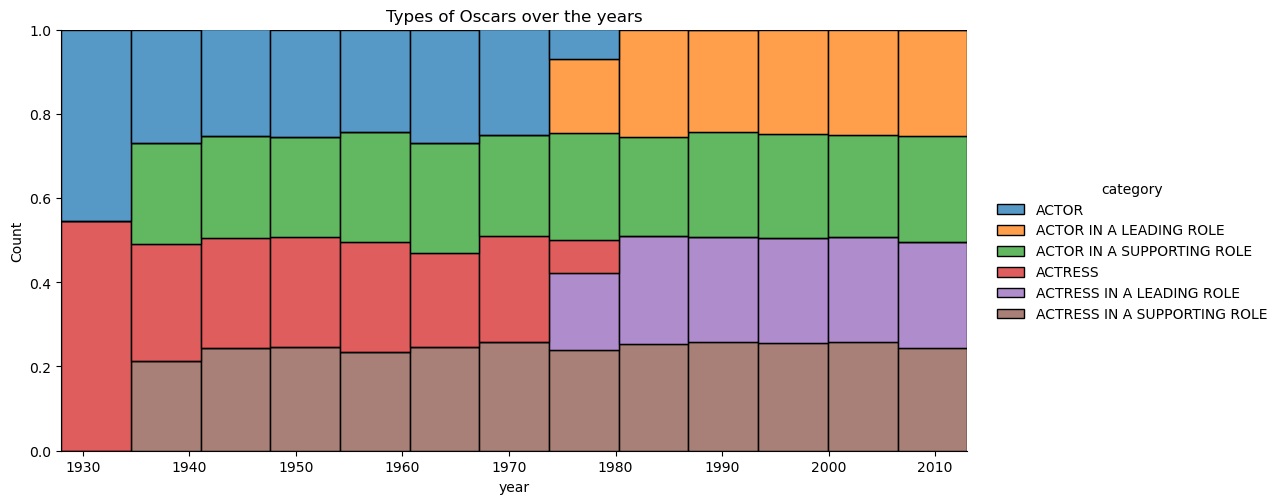

In [88]:
# Evolution of the types of Oscars given over the years
actors_oscars = actors.dropna(subset=['category'])
data = []

for cats in actors_oscars['category']:
    for film_id in cats:
        cat = cats[film_id]
        if cat[:3] == "ACT":
            movie = movies_load.query("fbID == '" + film_id + "'")
            year = movie["releaseYear"].values[0]
            data.append([year, cat])

data = pd.DataFrame(data, columns=["year", "category"])

sns.displot(
    data,
    x="year",
    hue="category",
    multiple="fill",
    hue_order=["ACTOR", "ACTOR IN A LEADING ROLE", "ACTOR IN A SUPPORTING ROLE", "ACTRESS", "ACTRESS IN A LEADING ROLE", "ACTRESS IN A SUPPORTING ROLE"],
    aspect=2,
)
plt.title("Types of Oscars over the years")
plt.show()

To better understand the different types of Oscars that can be given to an actor, we plotted the evolution of the categories of Oscars given over the time. An actor, an actress, can receive an Oscar for their performance either in a leading role or in a supporting role. This fact and the plot suggest that the values `ACTOR` / `ACTRESS` and `ACTOR IN A LEADING ROLE` / `ACTRESS IN A LEADING ROLE` actually represent the same type of oscar.

<Axes: title={'center': 'Number of Oscars nominees per year'}, xlabel='Year', ylabel='Number of oscars'>

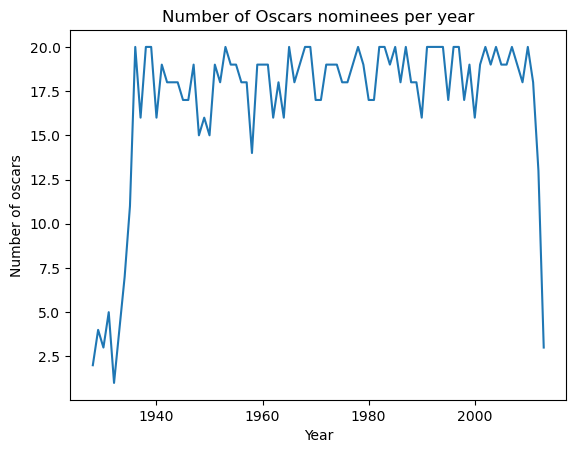

In [89]:
# Find the number of oscars given per year
years = []
for cats in actors_oscars['category']:
    for film_id in cats:
        movie = movies_load.query("fbID == '" + film_id + "'")
        year = movie["releaseYear"].values[0]
        years.append(year)

years = pd.Series(years).value_counts()
years.sort_index().plot(kind='line', linestyle='-', xlabel="Year", ylabel="Number of oscars", title="Number of Oscars nominees per year")

We can see that the number of Oscar nominees is rather constant over the years.

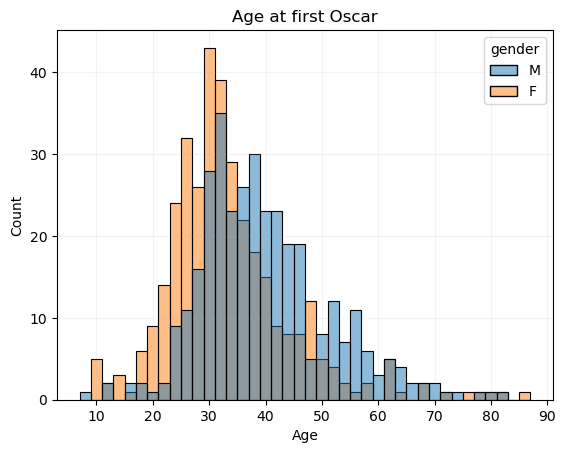

In [90]:
ages_at_first_oscar_nomination = []

for _, actor in actors_load.iterrows():
    min_age = 1000

    if type(actor["category"]) == float: # Ignore NaN
        continue

    for film_id in actor["category"]:
        try:
            if type(actor["ageAtMovieRelease"]) != float:
                age = actor["ageAtMovieRelease"][film_id]
                min_age = min(age, min_age)
        except KeyError:
            pass

    if min_age != 1000:
        ages_at_first_oscar_nomination.append([min_age, actor["actorGender"]])

ages_at_first_oscar_nomination = pd.DataFrame(ages_at_first_oscar_nomination, columns=["age", "gender"])

sns.histplot(ages_at_first_oscar_nomination, x="age", hue="gender", hue_order=["M", "F"], bins=40)
plt.title("Age at first Oscar")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

A person can obtain their first Oscar at any point of their life, but most obtain it between 30 years old and 50 years old. It is interesting to note that women tend to obtain it earlier than men.

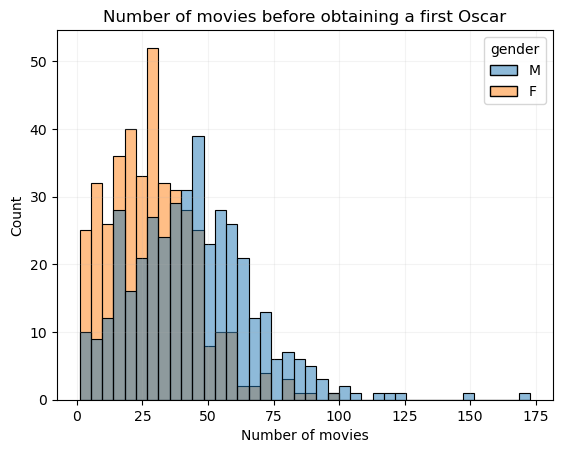

In [91]:
nb_films_at_first_oscar_nomination = []

for _, actor in actors_load.iterrows():
    if type(actor["category"]) == float: # Ignore NaN
        continue

    oscar_years = []

    for film_id in actor["category"]:
        movie = movies_load.query("fbID == '" + film_id + "'")
        year = movie["releaseYear"].values[0]
        oscar_years.append(year)
    
    if len(oscar_years) == 0:
        continue

    first_oscar_year = min(oscar_years)

    count = 0

    for movie_id in actor.fbID:
        movie = movies_load.query("fbID == '" + film_id + "'")
        year = movie["releaseYear"].values[0]

        if year >= first_oscar_year:
            count += 1
    
    nb_films_at_first_oscar_nomination.append([count, actor.actorGender])

nb_films_at_first_oscar_nomination = pd.DataFrame(nb_films_at_first_oscar_nomination, columns=["count", "gender"])

sns.histplot(nb_films_at_first_oscar_nomination, x="count", hue="gender", hue_order=["M", "F"], bins=40)
plt.title("Number of movies before obtaining a first Oscar")
plt.xlabel("Number of movies")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

## Saving Preprocessed Datasets

In [92]:
movies.to_csv(DATA_FOLDER + "movies.csv", index=False)
actors.to_csv(DATA_FOLDER + "actors.csv", index=False)

In [93]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genres": parse_list,
    },
)
display(actors_load)
display(movies_load)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,1964.0,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,1928.0,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,NaN,1977.0,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,Irish people,1930.0,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,1920.0,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48
...,...,...,...,...,...,...,...,...,...,...,...,...
135417,/m/0z58,Ardal O'Hanlon,M,1965-10-08,NaN,NaN,1965.0,[/m/027cvd8],NaN,NaN,NaN,1
135418,/m/0z9q0,"José Luis Rodríguez ""El Puma""",M,1943-01-14,NaN,NaN,1943.0,[/m/0gls5qd],{'/m/0gls5qd': 69.0},NaN,NaN,1
135419,/m/0zcb7,Marcus Giamatti,M,1961-10-03,1.850,NaN,1961.0,"[/m/02drs7, /m/03b1xl, /m/047fs6w, /m/080kkcx,...","{'/m/02drs7': 40.0, '/m/03b1xl': 29.0, '/m/047...",NaN,NaN,6
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,1967.0,"[/m/01510v, /m/01hv3t, /m/01pgnr, /m/024tb7, /...","{'/m/01510v': 31.0, '/m/01hv3t': 30.0, '/m/01p...",{'/m/050gkf': 'ACTOR IN A SUPPORTING ROLE'},{'/m/050gkf': False},54


,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes,combinedGenres,genres
0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,NaN,NaN,"['Mystery', 'Biographical film', 'Drama', 'Cri...",2.0,2000.0,tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0.0,\N,['Drama'],6.0,69.0,"{'Biographical film', 'Mystery', 'Drama', 'Cri...","{Mystery, Drama, Crime}"
1,/m/0crgdbh,Brun bitter,NaN,83.0,NaN,NaN,"['Crime Fiction', 'Drama']",NaN,1988.0,tt0094806,movie,Brun bitter,0.0,\N,"['Crime', 'Drama']",5.6,40.0,"{'Crime Fiction', 'Drama', 'Crime'}","{Drama, Fiction, Crime}"
2,/m/0285_cd,White Of The Eye,NaN,110.0,NaN,NaN,"['Thriller', 'Erotic thriller', 'Psychological...",NaN,1987.0,tt0094320,movie,White of the Eye,0.0,\N,"['Horror', 'Mystery', 'Thriller']",6.1,2885.0,"{'Thriller', 'Horror', 'Psychological thriller...","{Thriller, Horror, Mystery}"
3,/m/01mrr1,A Woman in Flames,NaN,106.0,NaN,NaN,['Drama'],NaN,1983.0,tt0083949,movie,Die flambierte Frau,0.0,\N,['Drama'],6.0,621.0,{'Drama'},{Drama}
4,/m/03cfc81,The Gangsters,NaN,35.0,NaN,NaN,"['Short Film', 'Silent film', 'Indie', 'Black-...",5.0,1913.0,tt0002894,short,The Gangsters,0.0,\N,"['Comedy', 'Short']",6.8,16.0,"{'Short Film', 'Silent film', 'Short', 'Black-...","{Short, Silent, Black-and-white, Indie, Comedy}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81621,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,NaN,NaN,['Drama'],3.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'Drama'},{Drama}
81622,/m/0g4pl34,Knuckle,NaN,96.0,NaN,NaN,"['Biographical film', 'Drama', 'Documentary']",1.0,2011.0,tt1606259,movie,Knuckle,0.0,\N,"['Biography', 'Documentary', 'Drama']",6.8,3190.0,"{'Biographical film', 'Biography', 'Documentar...","{Biography, Documentary, Drama}"
81623,/m/02pygw1,Another Nice Mess,NaN,66.0,NaN,NaN,"['Satire', 'Comedy']",9.0,1972.0,tt0362411,movie,Another Nice Mess,0.0,\N,['Comedy'],5.8,110.0,"{'Satire', 'Comedy'}",{Comedy}
81624,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,NaN,NaN,"['Science Fiction', 'Japanese Movies', 'Advent...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Animation', 'Short Film', 'Science Fiction',...","{Animation, Fiction, Short, Drama, Japanese, A..."
